### Semi-supervised learning
## Multi-tasking 
Data taken from https://www.kaggle.com/datasets/prathamgrover/3d-liver-segmentation?resource=download'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import os
import sys
import glob
import itertools
from pathlib import Path
cd= Path.cwd().parent
sys.path.append(str(cd))

from func.utill import visualize_slices, DiceLoss



c:\Users\gusta\miniforge3\envs\02452\Lib\site-packages\albumentations\check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()


In [2]:
# check size of all nii files in a folder
from pathlib import Path


def check_nii_sizes(folder_path):
    nii_files = glob.glob(os.path.join(folder_path, "*.nii"))
    for file in nii_files:
        img = nib.load(file)
        data = img.get_fdata()
        print(f"File: {os.path.basename(file)}, Shape: {data.shape}")
#PP

imagesTr = Path.cwd().parent / "Task03_Liver_rs" / "imagesTr"
labelsTr = Path.cwd().parent / "Task03_Liver_rs" / "labelsTr"
imagesUnlabeledTr = Path.cwd().parent / "Task03_Liver_rs" / "imagesUnlabeledTr"


In [3]:

INPUT_SHAPE = (28, 28, 28) # ( D, H, W)
NUM_CLASSES = 3  # Background, Segment 1, Segment 2
LATENT_DIM = 256 # RNN batch
BATCH_SIZE = 4
TIME_STEPS = 10 # Time series size 


class ConvBlock(nn.Module):
    """
    A 3D Convolutional block: Conv3D -> BatchNorm -> ReLU
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Seg_decoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.up_seg1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) # -> 64x14x14x14
        self.dec_seg1 = ConvBlock(128, 64) # add skip connection 64+64= 128
        
        self.up_seg2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2) # 32x28x28x28
        self.dec_seg2 = ConvBlock(64, 32) # add skip connection 32+32= 64
        
        self.out_seg = nn.Conv3d(32, num_classes, kernel_size=1) # Output segmentation
        
    def forward(self, b , s1, s2):
         # segmentation decoder forward step
        us1 = self.up_seg1(b) # -> Bx64x14x14x14
        ds1 = self.dec_seg1(torch.cat([us1, s2], dim=1)) # Concat skip 2
        
        us2 = self.up_seg2(ds1) # -> Bx32x28x28x28
        ds2 = self.dec_seg2(torch.cat([us2, s1], dim=1)) # Concat skip 1
        us3 = self.out_seg(ds2) 
        return us3
    
class Recon_decoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.up_recon1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) # ->64x14x14x14
        self.dec_recon1 = ConvBlock(64, 64)

        self.up_recon2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2) # -> 32x28x28x28
        self.dec_recon2 = ConvBlock(32, 32)

        self.out_recon = nn.Sequential(
            nn.Conv3d(32, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, b):
        ur1 = self.up_recon1(b)   # -> Bx64x14x14x14
        dr1 = self.dec_recon1(ur1)
        
        ur2 = self.up_recon2(dr1) # -> Bx3x28x28x28
        dr2 = self.dec_recon2(ur2)

        ur3 = self.out_recon(dr2) # -> Bx1x28x28x28

        return ur3

In [4]:

class MultiTaskNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=3, latent_dim=256):
        super().__init__()
        
        # Commen encoder
        # 1x28x28x28
        self.enc1 = ConvBlock(in_channels, 32) # -> 32x28x28x28
        self.pool1 = nn.MaxPool3d(2) # -> 32x14x14x14
        
        self.enc2 = ConvBlock(32, 64) # -> 64x14x14x14
        self.pool2 = nn.MaxPool3d(2) # -> 64x7x7x7
        
        # Bottleneck 
        self.bottleneck = ConvBlock(64, 128) # -> 128x7x7x7
        
        # Feature vector for rnn input
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.to_latent_vec = nn.Linear(128, latent_dim) # -> Bx256x

        # First decoder head for segmentation with skipped connect
        self.seg_decoder = Seg_decoder(num_classes=num_classes)
        self.sigmoid = nn.Sigmoid()

        # Second decoder head reconstruction without skipped
        self.recon_decoder = Recon_decoder(in_channels=in_channels)
        

    def forward(self, x):
        # commen encoder
        s1 = self.enc1(x)       # -> Bx32x28x28x28]
        p1 = self.pool1(s1)     # -> Bx32x14x14x14
        
        s2 = self.enc2(p1)      # -> Bx64x14x14x14
        p2 = self.pool2(s2)     # -> Bx64x7x7x7x
        
        # bottleneck -> could be variational
        b = self.bottleneck(p2) # [B, 128, 7, 7, 7]

        # Vectorize bottleneck output 
        pooled_vec = self.global_pool(b).view(b.size(0), -1) # -<Bx128
        latent_z = self.to_latent_vec(pooled_vec)            # ->Bx256

        # Segmentation decoder head with skips
        seg_output = self.seg_decoder(b, s1, s2)
        seg_output = self.sigmoid(seg_output)

        # Reconstruction decoder head without skips
        recon_output = self.recon_decoder(b)
        
        return seg_output, recon_output, latent_z


# Temporal model -> could add more dimension 
class TemporalTracker(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True 
        )

        # predict t+1
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, z_sequence):
        # z_sequence shape -> Batch x Time_Steps x latent_dim
        lstm_out, _ = self.lstm(z_sequence)
        
        # only care about t+1
        last_step_out = lstm_out[:, -1, :] # -1 last time step +1 
        
        # fc layer for prediction
        prediction = self.fc(last_step_out)
        return prediction


In [5]:
class LiverDataset(Dataset):
    """
    Made by AI
    Custom PyTorch Dataset for the 3D Liver Segmentation data.
    """
    def __init__(self, image_dir, label_dir, target_size=INPUT_SHAPE):
        print(image_dir)
        print(label_dir)
        # --- THIS IS THE CORRECTED PART (looking for .nii) ---
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "imagesTr","*.nii")))
        self.label_paths = sorted(glob.glob(os.path.join(label_dir, "labelsTr" , "*.nii")))      
        self.target_size = target_size # (D, H, W)
        
        # Ensure we have matched pairs
        assert len(self.image_paths) > 0, f"No images found in {image_dir}"
        assert len(self.label_paths) > 0, f"No labels found in {label_dir}"
        assert len(self.image_paths) == len(self.label_paths), \
            f"Found {len(self.image_paths)} images but {len(self.label_paths)} labels."
        
        print(f"Found {len(self.image_paths)} image/label pairs.")

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, data):
        # Normalize pixel values to [0, 1]
        data = data - torch.min(data)
        data = data / torch.max(data)
        return data

    def __getitem__(self, idx):
        # 1. Load NIfTI files (nibabel handles .nii and .nii.gz the same way)
        img_nii = nib.load(self.image_paths[idx])
        lbl_nii = nib.load(self.label_paths[idx])
        
        # 2. Get data as numpy array and convert to tensor
        img_tensor = torch.from_numpy(img_nii.get_fdata()).float().permute(2, 1, 0).unsqueeze(0)
        lbl_tensor = torch.from_numpy(lbl_nii.get_fdata()).long().permute(2, 1, 0).unsqueeze(0)

        # 3. Resize
        img_resized = F.interpolate(img_tensor.unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='trilinear', 
                                    align_corners=False).squeeze(0)
        
        lbl_resized = F.interpolate(lbl_tensor.float().unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='nearest').squeeze(0).long()

        # 4. Normalize image
        img_resized = self.normalize(img_resized)

        # Squeeze the channel dim from the label
        lbl_resized = lbl_resized.squeeze(0) 

        return img_resized, lbl_resized

In [6]:
class LiverUnlabeledDataset(Dataset):
    """
    made by AI
    Custom PyTorch Dataset for 3D Liver UNLABELED images.
    Loads only images and returns them as a 1-item tuple.
    """
    def __init__(self, image_dir, target_size=INPUT_SHAPE, subfolder="imagesTr"):
        # Assumes unlabeled images are in a folder like 'imagesUnlabeledTr'
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, subfolder, "*.nii")))
        self.target_size = target_size # (D, H, W)
        
        assert len(self.image_paths) > 0, f"No unlabeled images found in {os.path.join(image_dir, subfolder)}"
        print(f"Found {len(self.image_paths)} unlabeled images.")

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, data):
        # Normalize pixel values to [0, 1]
        data = data - torch.min(data)
        data = data / torch.max(data)
        return data

    def __getitem__(self, idx):
        # 1. Load NIfTI file
        img_nii = nib.load(self.image_paths[idx])
        
        # 2. Get data as numpy array and convert to tensor
        img_tensor = torch.from_numpy(img_nii.get_fdata()).float().permute(2, 1, 0).unsqueeze(0)

        # 3. Resize
        img_resized = F.interpolate(img_tensor.unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='trilinear', 
                                    align_corners=False).squeeze(0)
        
        # 4. Normalize image
        img_resized = self.normalize(img_resized)

        # 5. Return as a 1-item tuple
        # This is important so the loop `(x_unlabeled)` unpacks correctly
        return (img_resized,)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


DATA_DIR = "./Task03_Liver_rs" 
# This one path points to the root directory (e.g., ./Task03_Liver_rs)
data_root_folder = Path.cwd().parent / DATA_DIR


try:
    # labeled set
    labeled_dataset = LiverDataset(image_dir=data_root_folder, label_dir=data_root_folder, target_size= INPUT_SHAPE)
    
    #DataLoader for labeled data
    labeled_loader = DataLoader(
        dataset=labeled_dataset,
        batch_size=BATCH_SIZE,

        shuffle=True
    )
    print("--- success ---")

except Exception as e:
    print(f"Error creating Labeled dataset: {e}")
    exit()

try:

    unlabeled_dataset = LiverUnlabeledDataset(
        image_dir=data_root_folder, 
        subfolder="imagesUnlabelledTr",
        target_size= INPUT_SHAPE
    )
    
    # 
    unlabeled_loader = DataLoader(
        dataset=unlabeled_dataset,
        batch_size=BATCH_SIZE, 
        shuffle=True
    )
    print("--- success ---")

except Exception as e:
    print(f"Error creating Unlabeled dataset: {e}")
    exit()

Using device: cpu
c:\Users\gusta\UniGit\02456-final-project\Task03_Liver_rs
c:\Users\gusta\UniGit\02456-final-project\Task03_Liver_rs
Found 105 image/label pairs.
--- success ---
Found 18 unlabeled images.
--- success ---


--- Training the MultiTaskNet on Liver Data ---

--- Epoch 1/31 ---
Batch 0/27 | Total Loss: 1.2070 | Recon Loss (Total): 0.2665 | CE Loss (Labeled): 1.0737 (Dice not active)
--- Visualizing first training batch (Labeled Data) ---


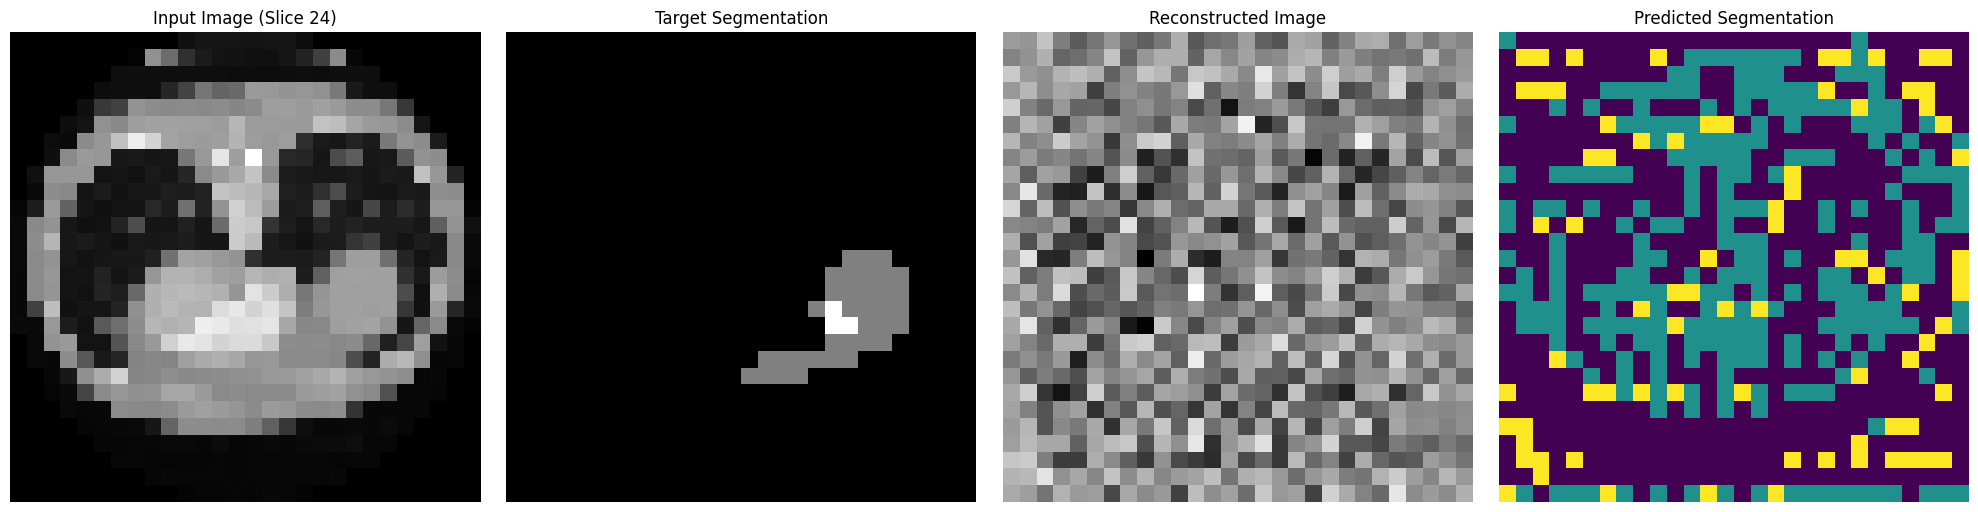


--- Epoch 2/31 ---
Batch 0/27 | Total Loss: 0.9271 | Recon Loss (Total): 0.0518 | CE Loss (Labeled): 0.9012 (Dice not active)

--- Epoch 3/31 ---
Batch 0/27 | Total Loss: 0.8444 | Recon Loss (Total): 0.0428 | CE Loss (Labeled): 0.8230 (Dice not active)

--- Epoch 4/31 ---
Batch 0/27 | Total Loss: 0.7485 | Recon Loss (Total): 0.0227 | CE Loss (Labeled): 0.7371 (Dice not active)

--- Epoch 5/31 ---
Batch 0/27 | Total Loss: 0.7049 | Recon Loss (Total): 0.0191 | CE Loss (Labeled): 0.6953 (Dice not active)

--- Epoch 6/31 ---
Batch 0/27 | Total Loss: 0.6607 | Recon Loss (Total): 0.0135 | CE Loss (Labeled): 0.6539 (Dice not active)

--- Epoch 7/31 ---
Batch 0/27 | Total Loss: 0.6298 | Recon Loss (Total): 0.0107 | CE Loss (Labeled): 0.6245 (Dice not active)

--- Epoch 8/31 ---
Batch 0/27 | Total Loss: 0.6127 | Recon Loss (Total): 0.0108 | CE Loss (Labeled): 0.6073 (Dice not active)

--- Epoch 9/31 ---
Batch 0/27 | Total Loss: 0.6065 | Recon Loss (Total): 0.0122 | CE Loss (Labeled): 0.6004 (D

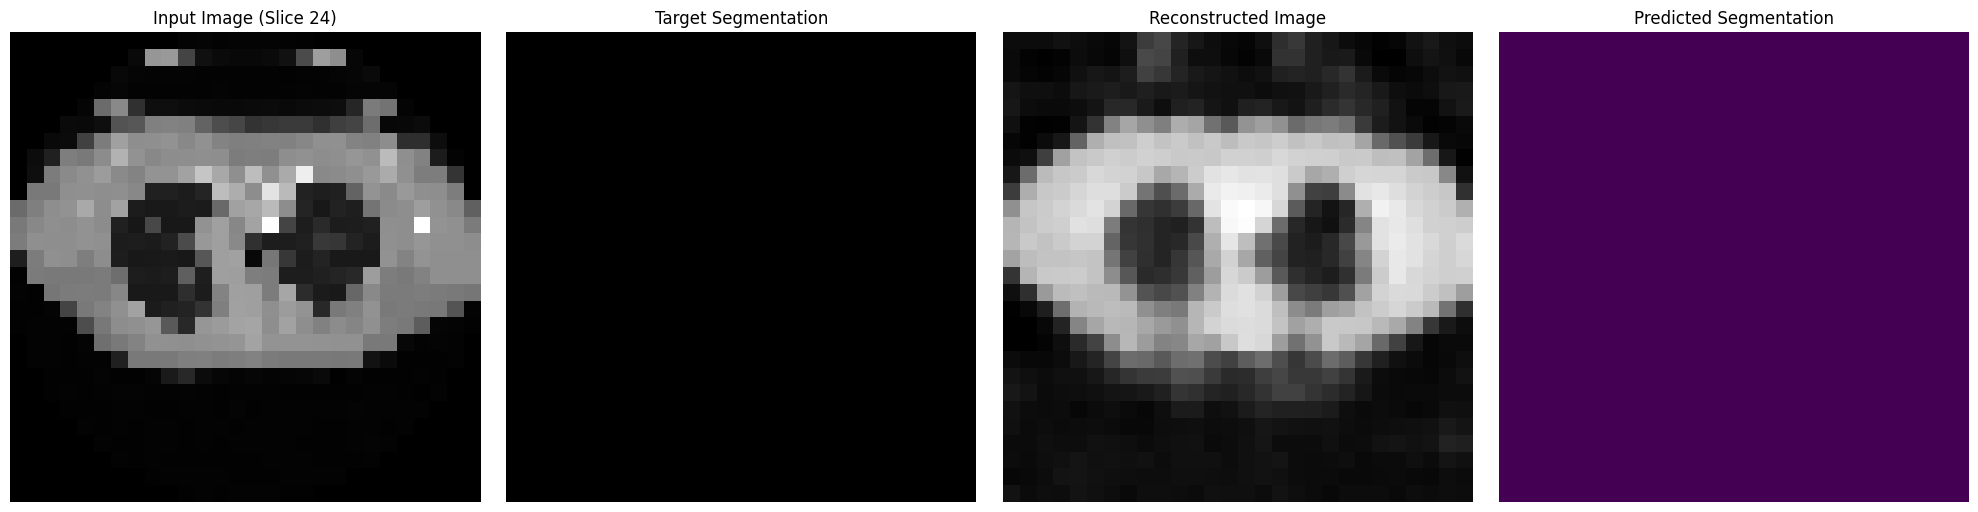


--- Epoch 12/31 ---
Batch 0/27 | Total Loss: 1.5371 | Recon Loss (Total): 0.0119 | CE Loss (Labeled): 0.5802 | DICE Loss (Labeled): 0.9509

--- Epoch 13/31 ---
Batch 0/27 | Total Loss: 1.5075 | Recon Loss (Total): 0.0092 | CE Loss (Labeled): 0.5784 | DICE Loss (Labeled): 0.9245

--- Epoch 14/31 ---
Batch 0/27 | Total Loss: 1.5177 | Recon Loss (Total): 0.0086 | CE Loss (Labeled): 0.5739 | DICE Loss (Labeled): 0.9396

--- Epoch 15/31 ---
Batch 0/27 | Total Loss: 1.4947 | Recon Loss (Total): 0.0107 | CE Loss (Labeled): 0.5732 | DICE Loss (Labeled): 0.9161

--- Epoch 16/31 ---
Batch 0/27 | Total Loss: 1.5067 | Recon Loss (Total): 0.0091 | CE Loss (Labeled): 0.5699 | DICE Loss (Labeled): 0.9323

--- Epoch 17/31 ---
Batch 0/27 | Total Loss: 1.5321 | Recon Loss (Total): 0.0096 | CE Loss (Labeled): 0.5675 | DICE Loss (Labeled): 0.9598

--- Epoch 18/31 ---
Batch 0/27 | Total Loss: 1.5095 | Recon Loss (Total): 0.0087 | CE Loss (Labeled): 0.5676 | DICE Loss (Labeled): 0.9376

--- Epoch 19/31 ---

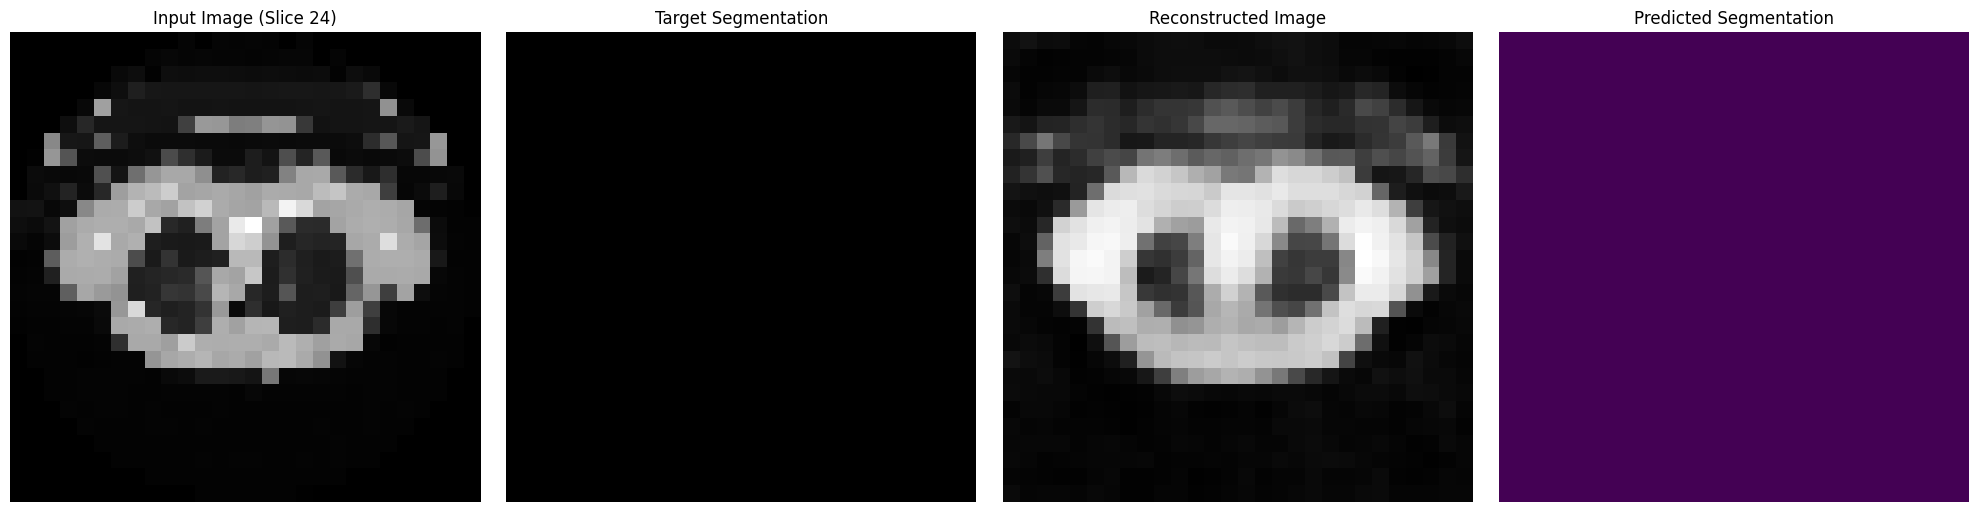


--- Epoch 22/31 ---
Batch 0/27 | Total Loss: 1.5035 | Recon Loss (Total): 0.0073 | CE Loss (Labeled): 0.5649 | DICE Loss (Labeled): 0.9349

--- Epoch 23/31 ---
Batch 0/27 | Total Loss: 1.5072 | Recon Loss (Total): 0.0067 | CE Loss (Labeled): 0.5641 | DICE Loss (Labeled): 0.9397

--- Epoch 24/31 ---
Batch 0/27 | Total Loss: 1.5278 | Recon Loss (Total): 0.0081 | CE Loss (Labeled): 0.5615 | DICE Loss (Labeled): 0.9622

--- Epoch 25/31 ---
Batch 0/27 | Total Loss: 1.4968 | Recon Loss (Total): 0.0061 | CE Loss (Labeled): 0.5612 | DICE Loss (Labeled): 0.9326

--- Epoch 26/31 ---
Batch 0/27 | Total Loss: 1.4965 | Recon Loss (Total): 0.0068 | CE Loss (Labeled): 0.5608 | DICE Loss (Labeled): 0.9323

--- Epoch 27/31 ---
Batch 0/27 | Total Loss: 1.5268 | Recon Loss (Total): 0.0077 | CE Loss (Labeled): 0.5631 | DICE Loss (Labeled): 0.9599

--- Epoch 28/31 ---
Batch 0/27 | Total Loss: 1.5032 | Recon Loss (Total): 0.0071 | CE Loss (Labeled): 0.5621 | DICE Loss (Labeled): 0.9375

--- Epoch 29/31 ---

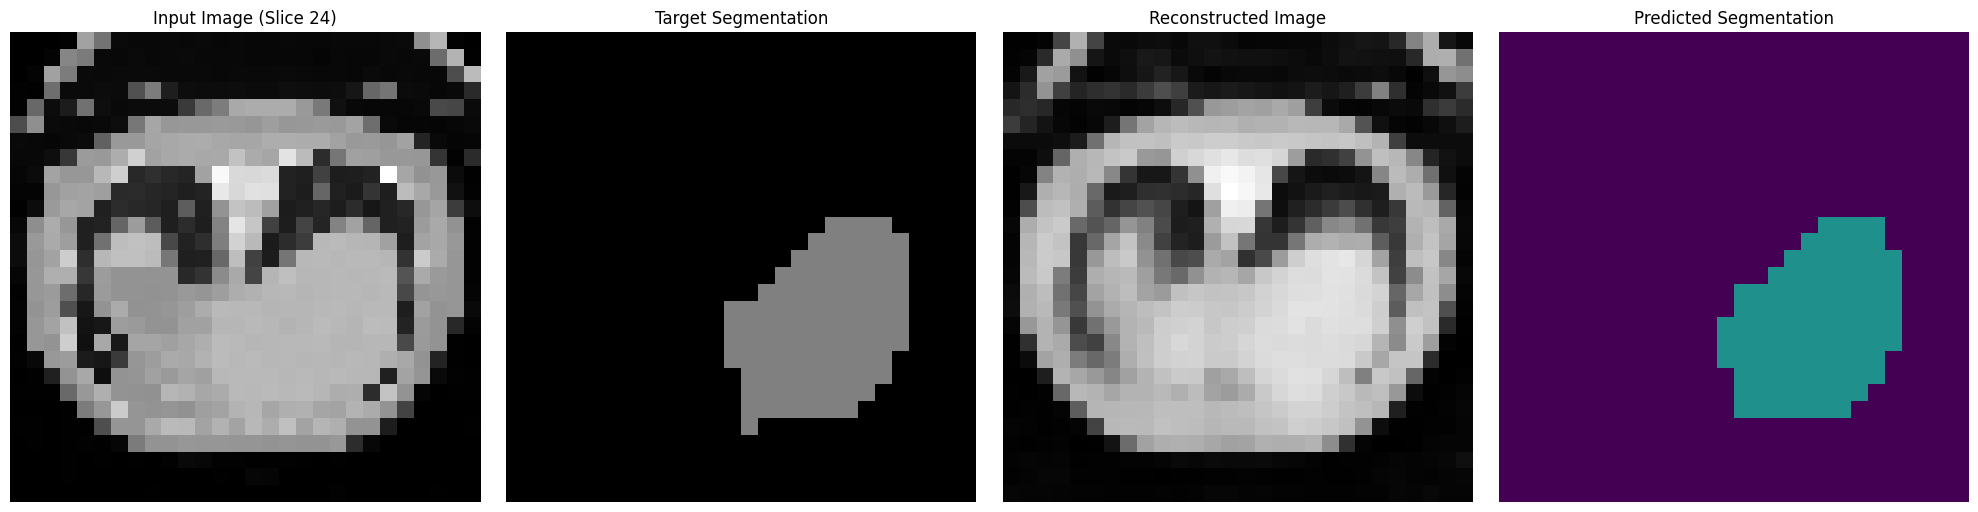

In [8]:

if __name__ == "__main__":
    # start model
    model = MultiTaskNet(
        in_channels=1, 
        num_classes=NUM_CLASSES, 
        latent_dim=LATENT_DIM  
    ).to(device)

    # define loss and optimizer
    loss_fn_seg_dice = DiceLoss(num_classes= NUM_CLASSES)
    loss_fn_seg_cross = nn.CrossEntropyLoss()
    loss_fn_recon = nn.MSELoss()
    optimizer_model = optim.Adam(model.parameters(), lr=1e-3)

    print("--- Training the MultiTaskNet on Liver Data ---")
    NUM_EPOCHS = 31

    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
        model.train() 
        
        # iterate over both loaders
        for batch_idx, ((x_labeled, y_seg_target), (x_unlabeled)) in \
                enumerate(zip(labeled_loader, itertools.cycle(unlabeled_loader))):
            
            # Move all data to device
            x_labeled = x_labeled.to(device)
            y_seg_target = y_seg_target
            x_unlabeled = x_unlabeled
            x_unlabeled = x_unlabeled[0]

            optimizer_model.zero_grad()
            
            # forward pass on labeled data for both seg and recon
            seg_out, recon_out_labeled, _ = model(x_labeled)
            
            # segmentation losses
            loss_seg_cross = loss_fn_seg_cross(seg_out, y_seg_target)
            
            total_loss_seg = loss_seg_cross * 1.0
            loss_seg_dice = 0.0
            
            # add dice loss if cross entropy is low enough
            if loss_seg_cross.item() < 0.6:
                dice_loss_component = loss_fn_seg_dice(seg_out, y_seg_target)
                total_loss_seg = total_loss_seg + (dice_loss_component * 1)
                loss_seg_dice = dice_loss_component.item()
                
            # labeled recon loss
            loss_recon_labeled = loss_fn_recon(recon_out_labeled, x_labeled)
                
            # Forward pass only on unlabeled data for recon
            _ , recon_out_unlabeled, _ = model(x_unlabeled)
            
            # unlabeled recon loss
            loss_recon_unlabeled = loss_fn_recon(recon_out_unlabeled, x_unlabeled)
            
            # Total recon loss
            total_loss_recon = loss_recon_labeled + loss_recon_unlabeled
            
            # Total combined loss
            total_loss = total_loss_seg + (total_loss_recon * 0.5) 
                
            total_loss.backward()
            optimizer_model.step()
            
            # Udate Logging
            if batch_idx % 30 == 0:
                if loss_seg_cross.item() > 0.6:
                    print(f"Batch {batch_idx}/{len(labeled_loader)} | Total Loss: {total_loss.item():.4f} | Recon Loss (Total): {total_loss_recon.item():.4f} | CE Loss (Labeled): {loss_seg_cross.item():.4f} (Dice not active)")
                else:
                    print(f"Batch {batch_idx}/{len(labeled_loader)} | Total Loss: {total_loss.item():.4f} | Recon Loss (Total): {total_loss_recon.item():.4f} | CE Loss (Labeled): {loss_seg_cross.item():.4f} | DICE Loss (Labeled): {loss_seg_dice:.4f}")
            
            # visualization update
            if epoch % 10 == 0 and batch_idx % 30 == 0:
                print("--- Visualizing first training batch (Labeled Data) ---")
                visualize_slices(x_labeled, y_seg_target, recon_out_labeled, seg_out)

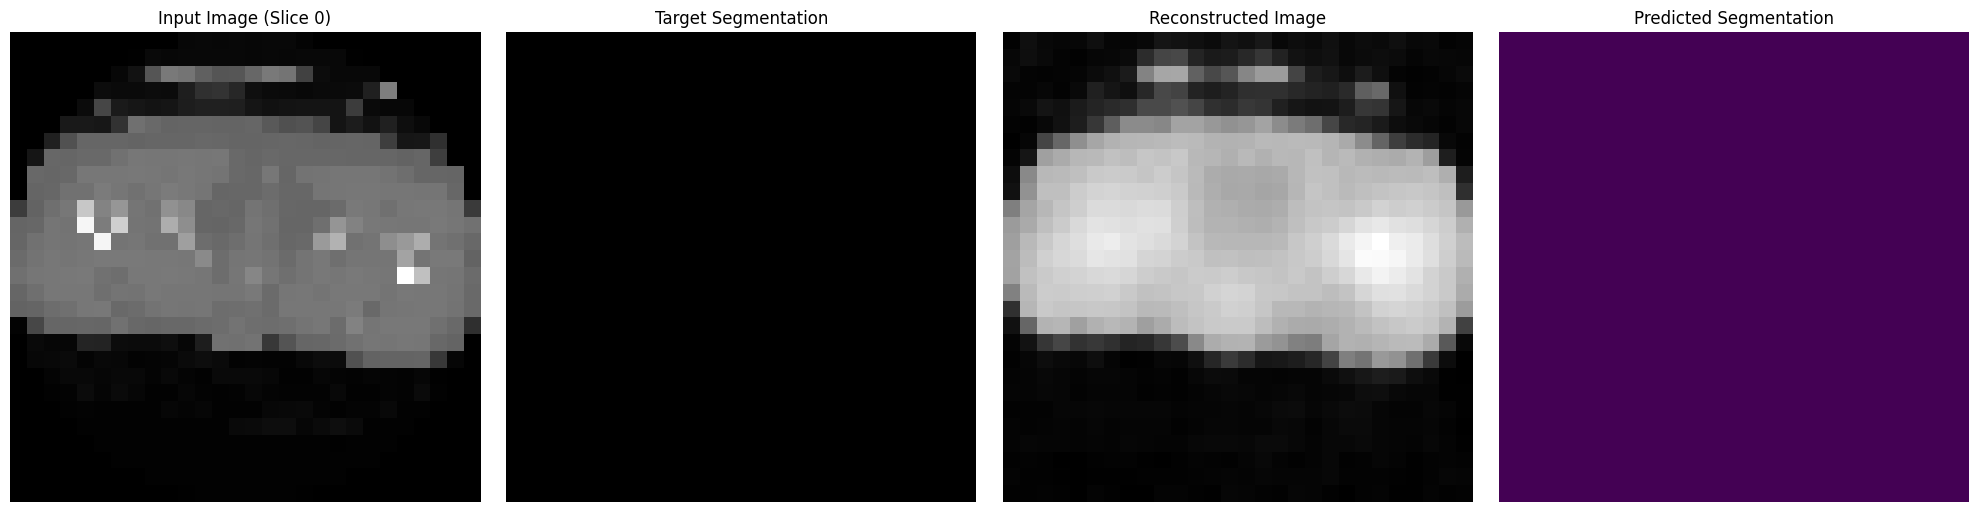

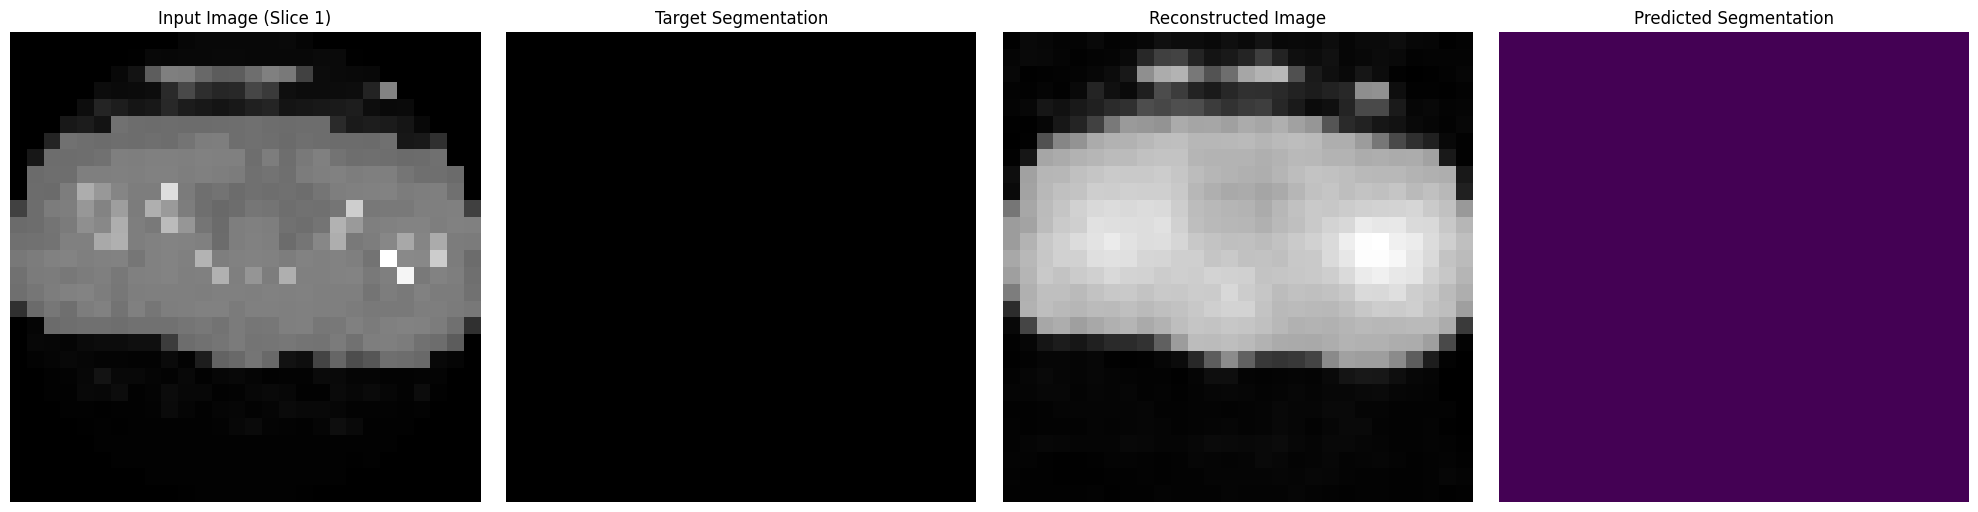

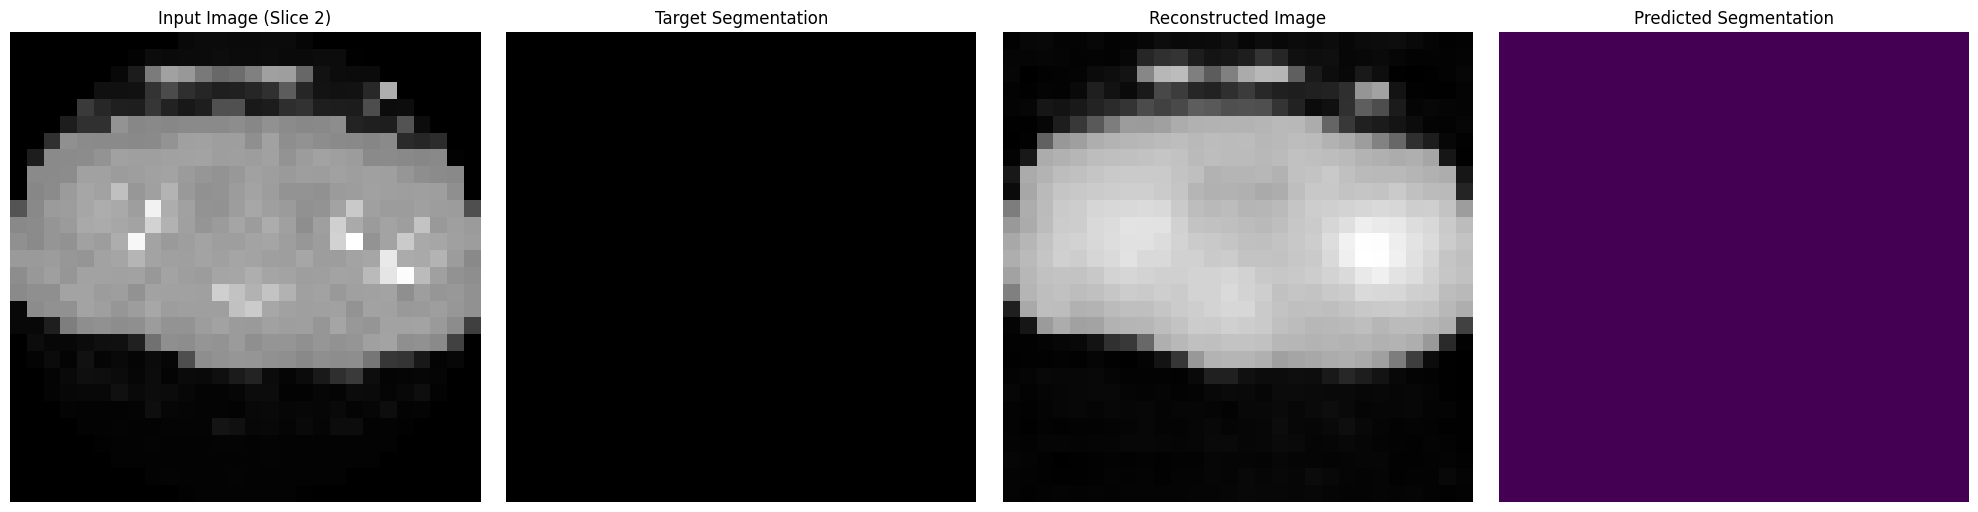

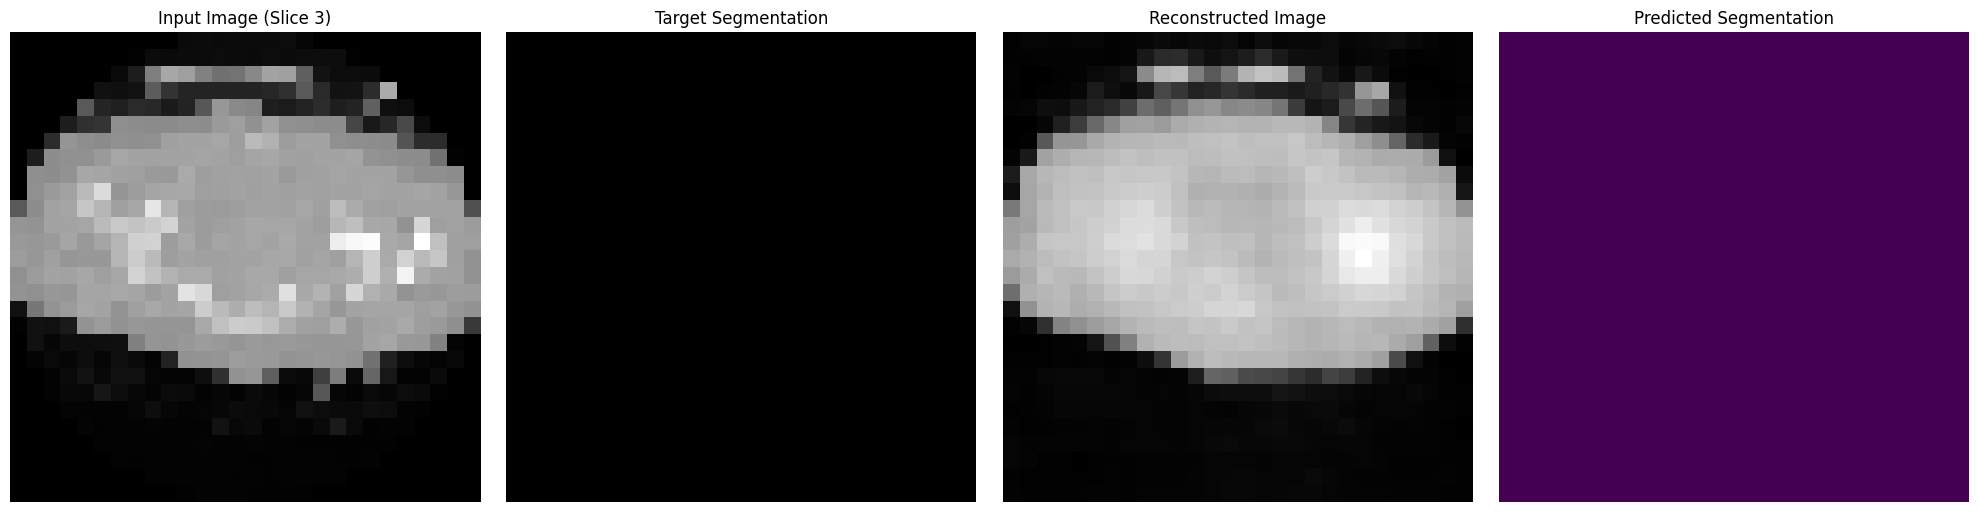

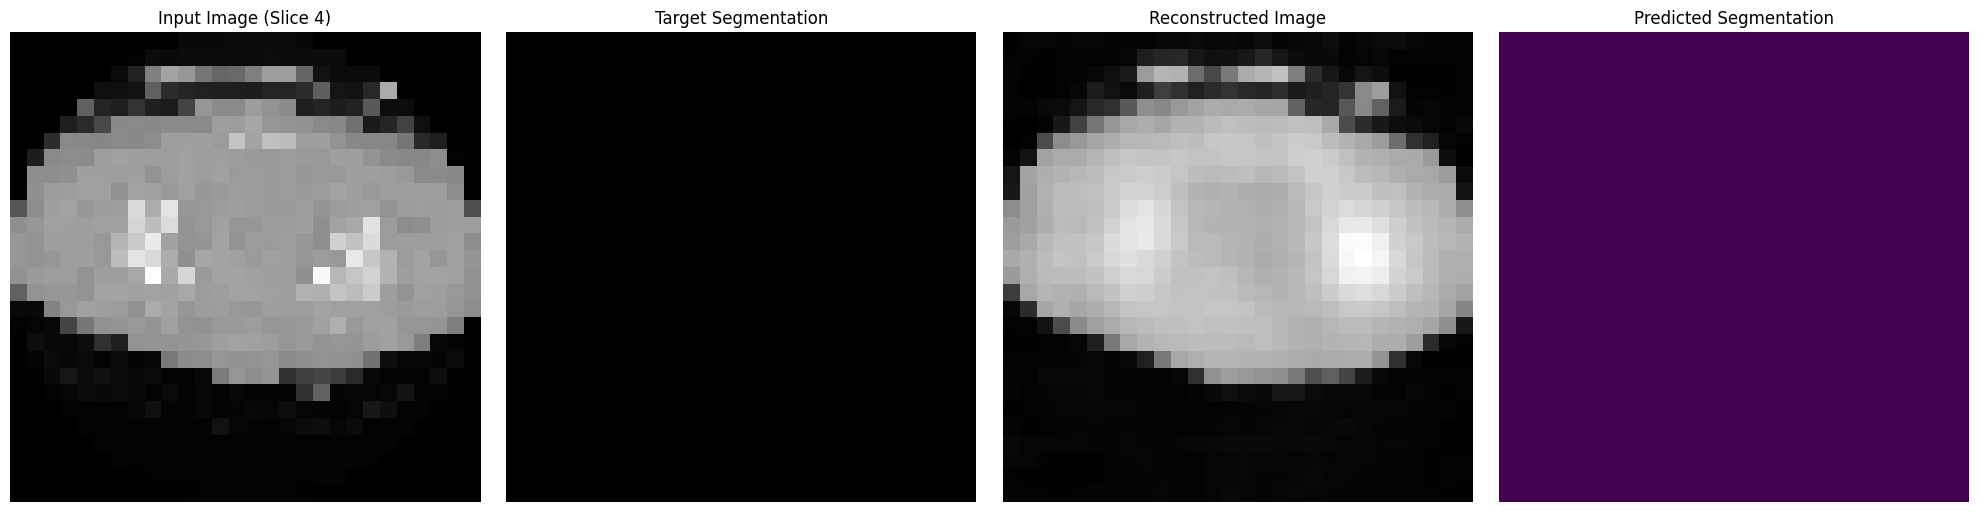

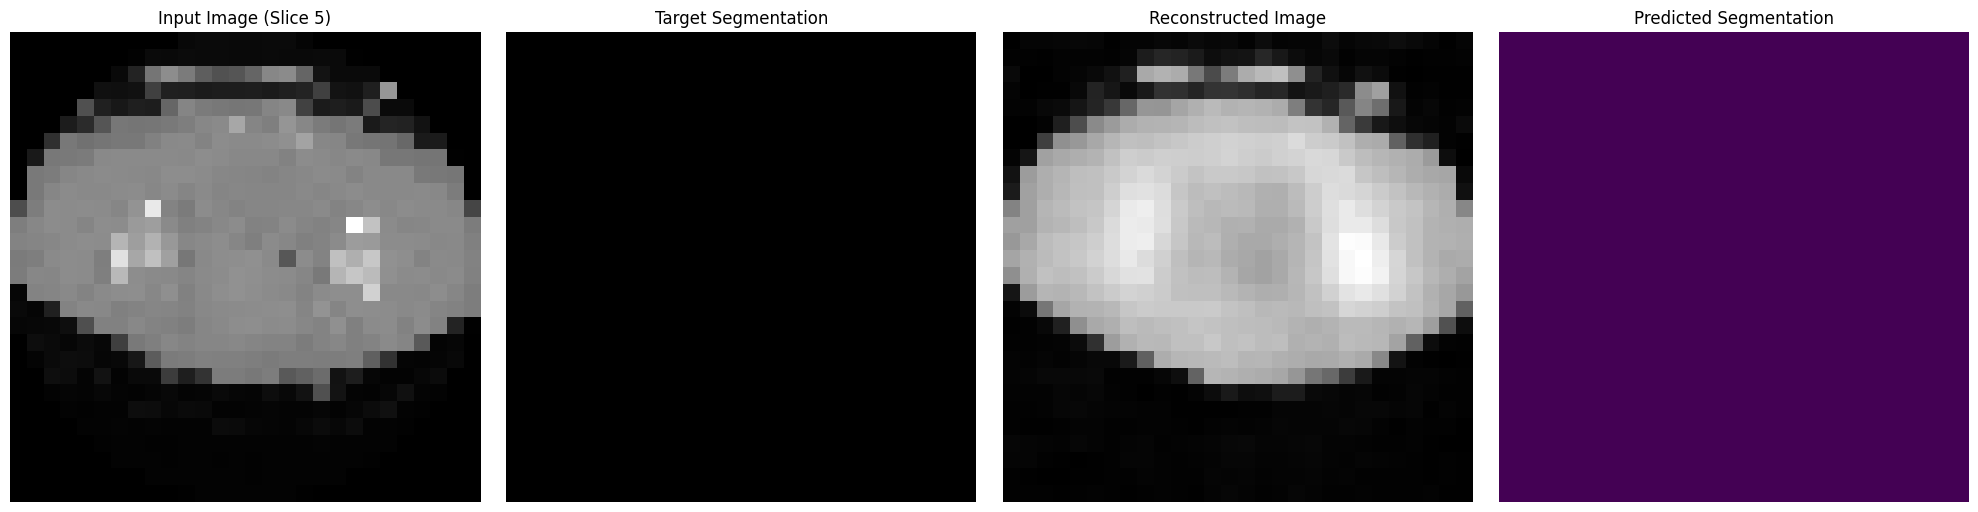

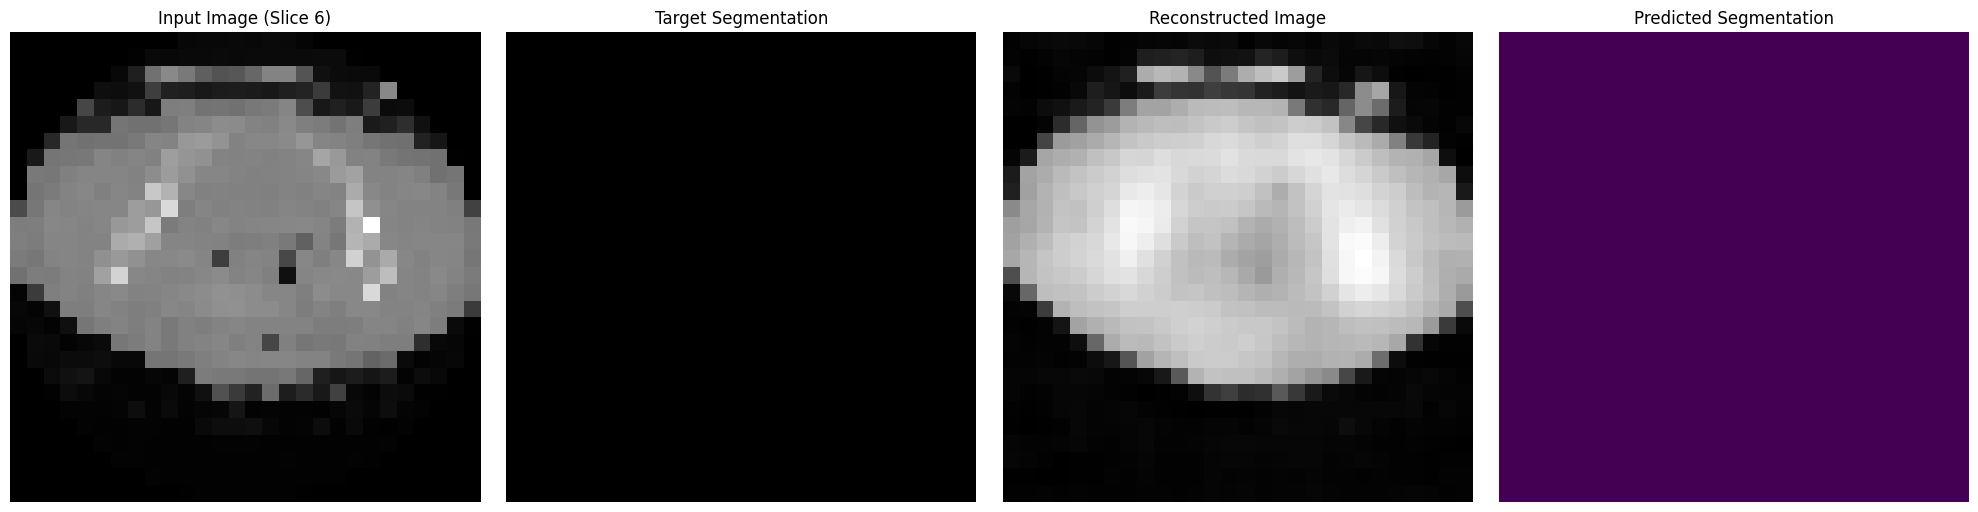

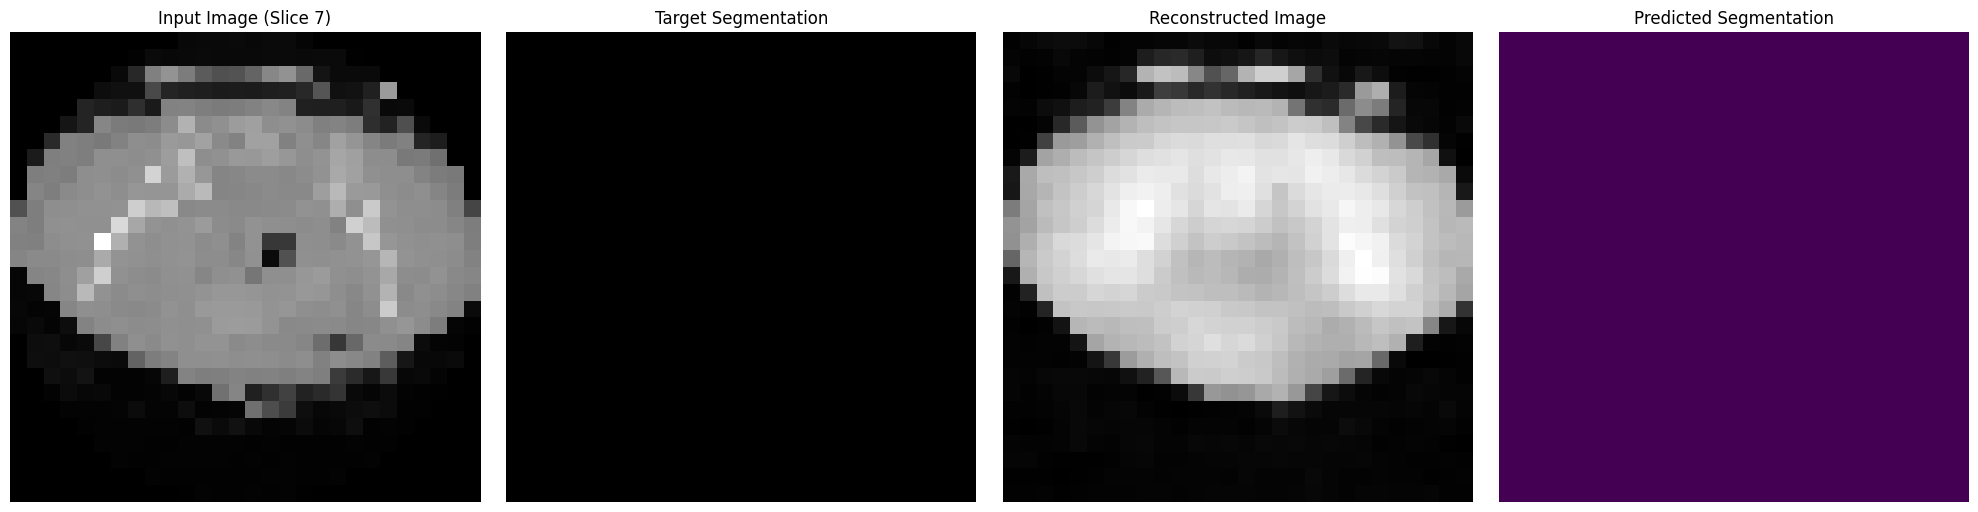

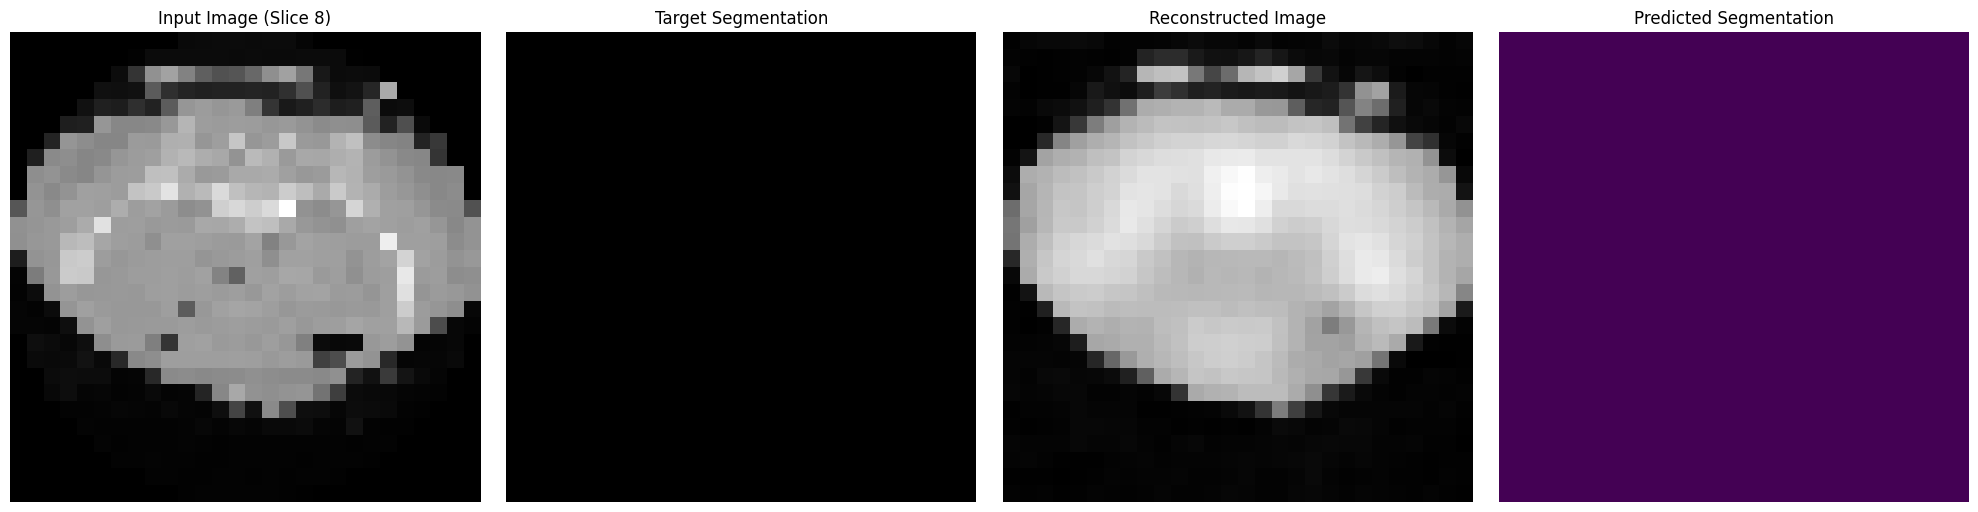

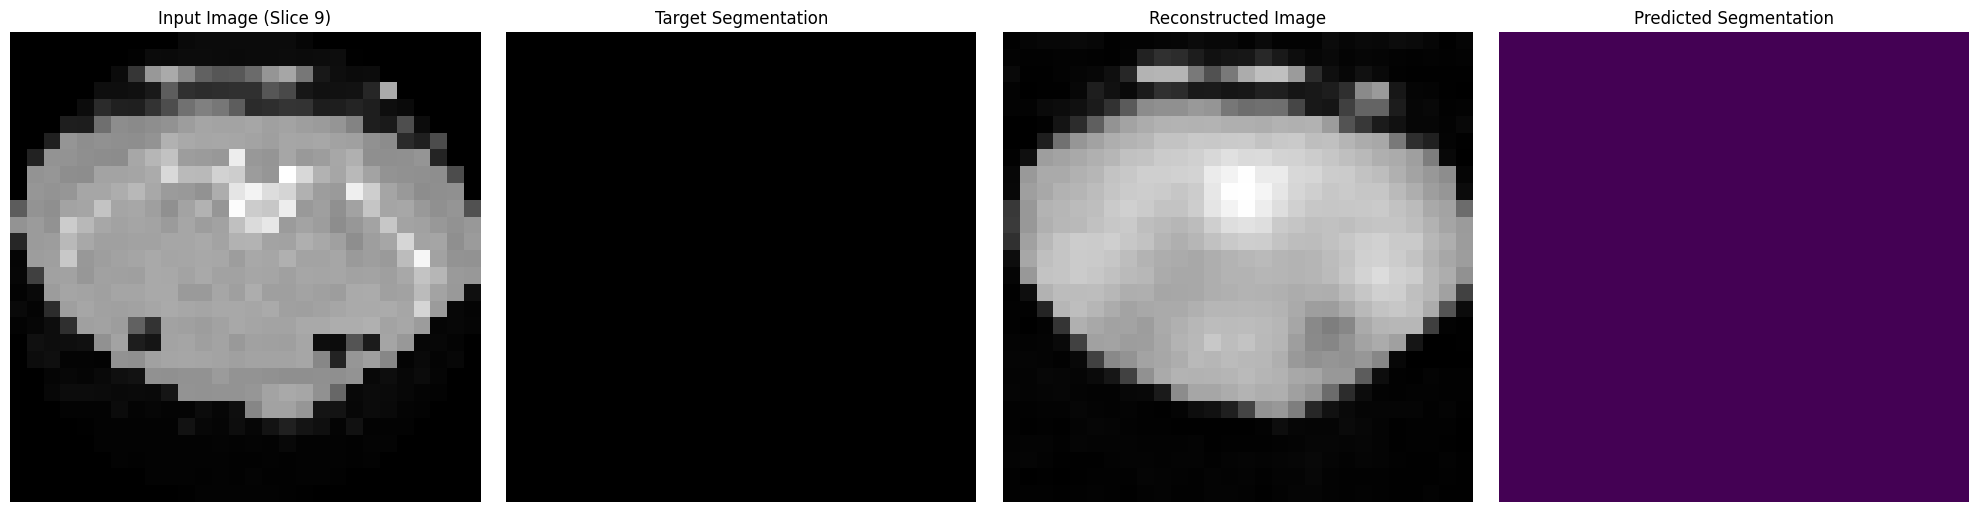

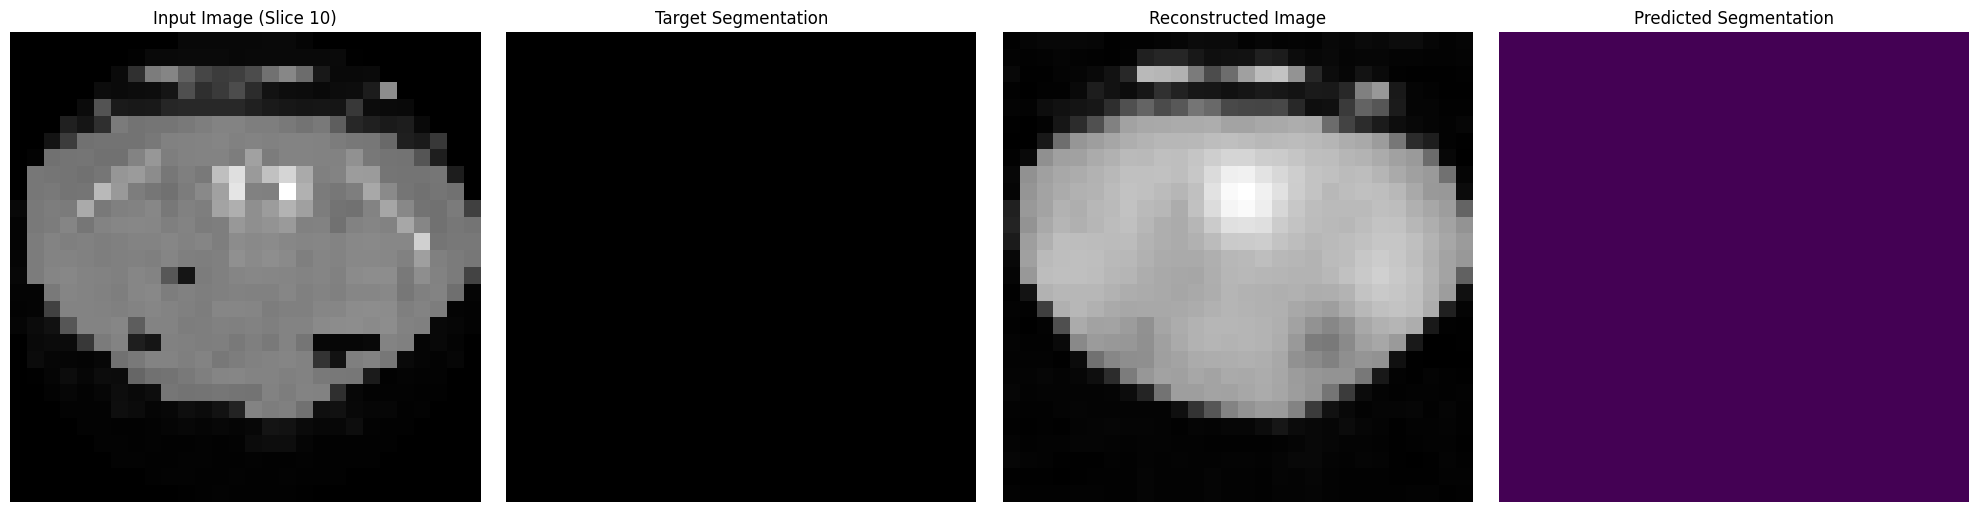

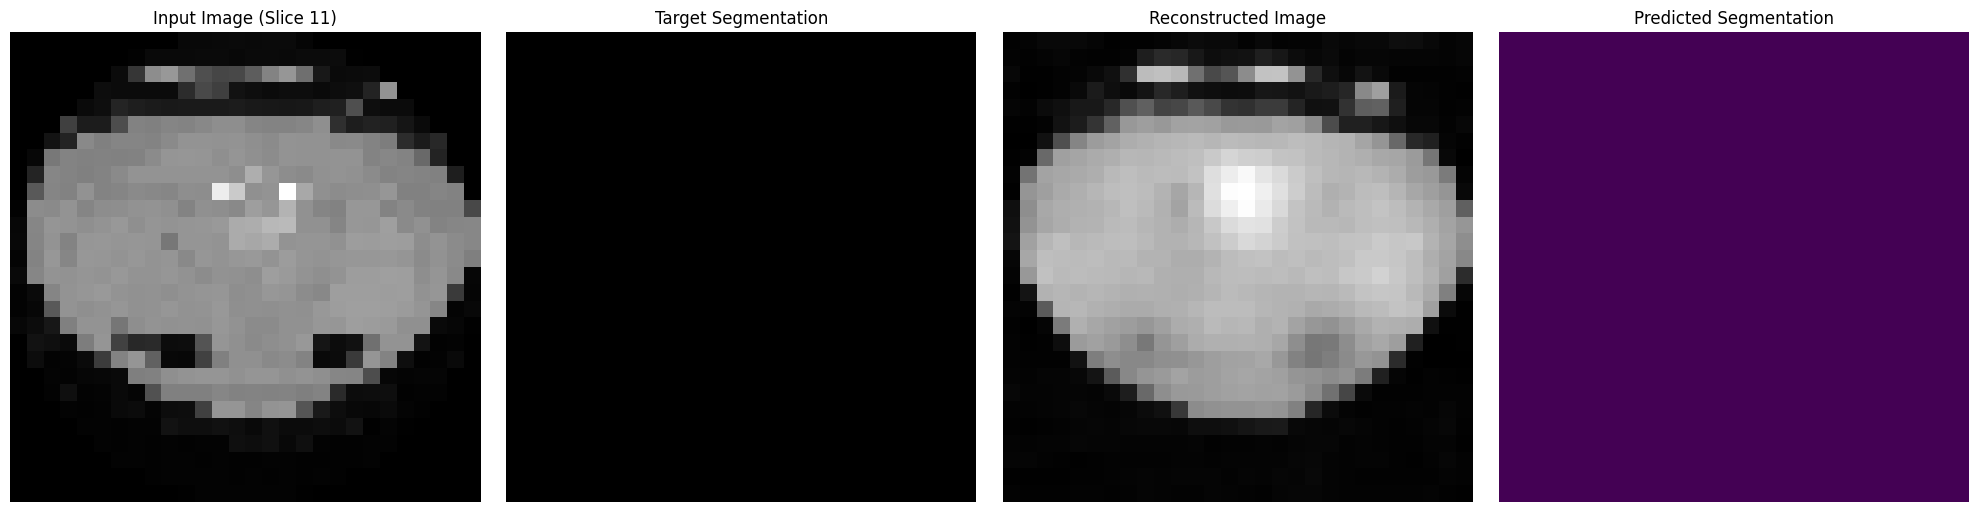

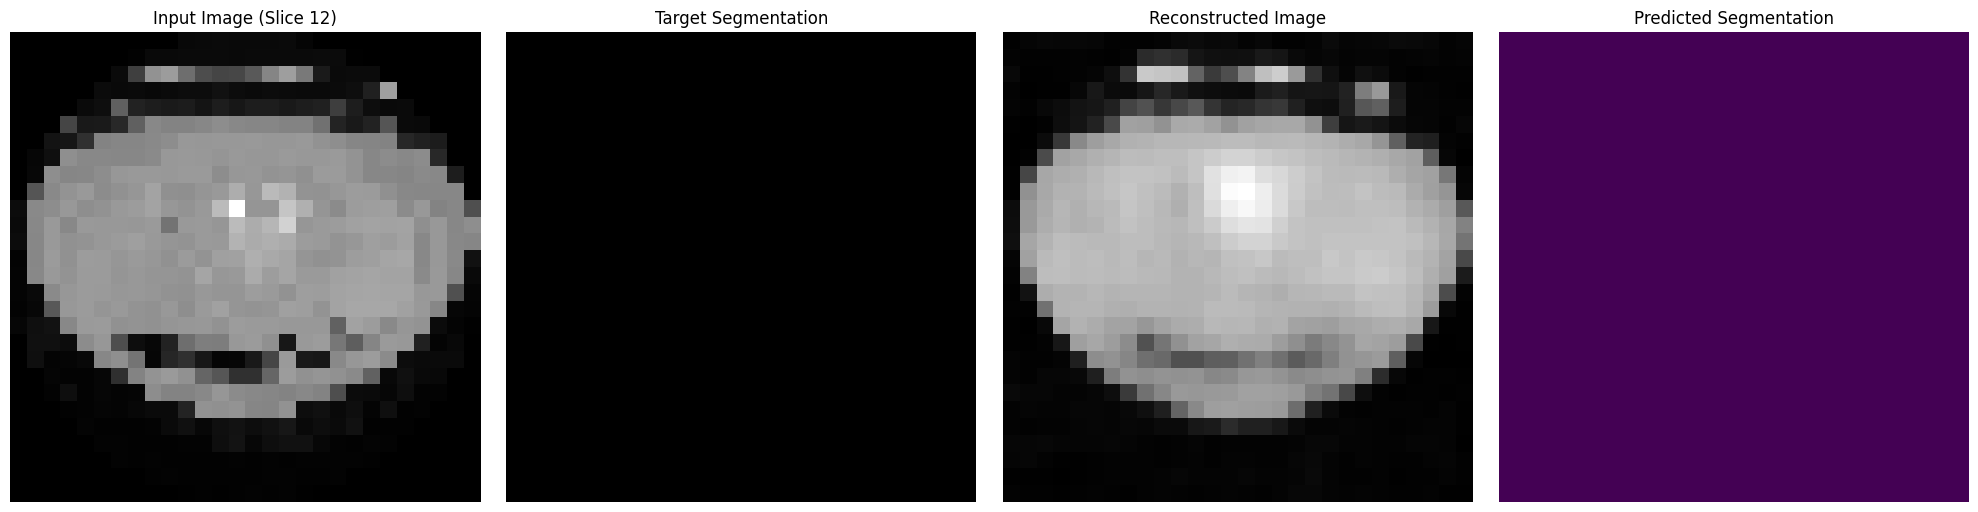

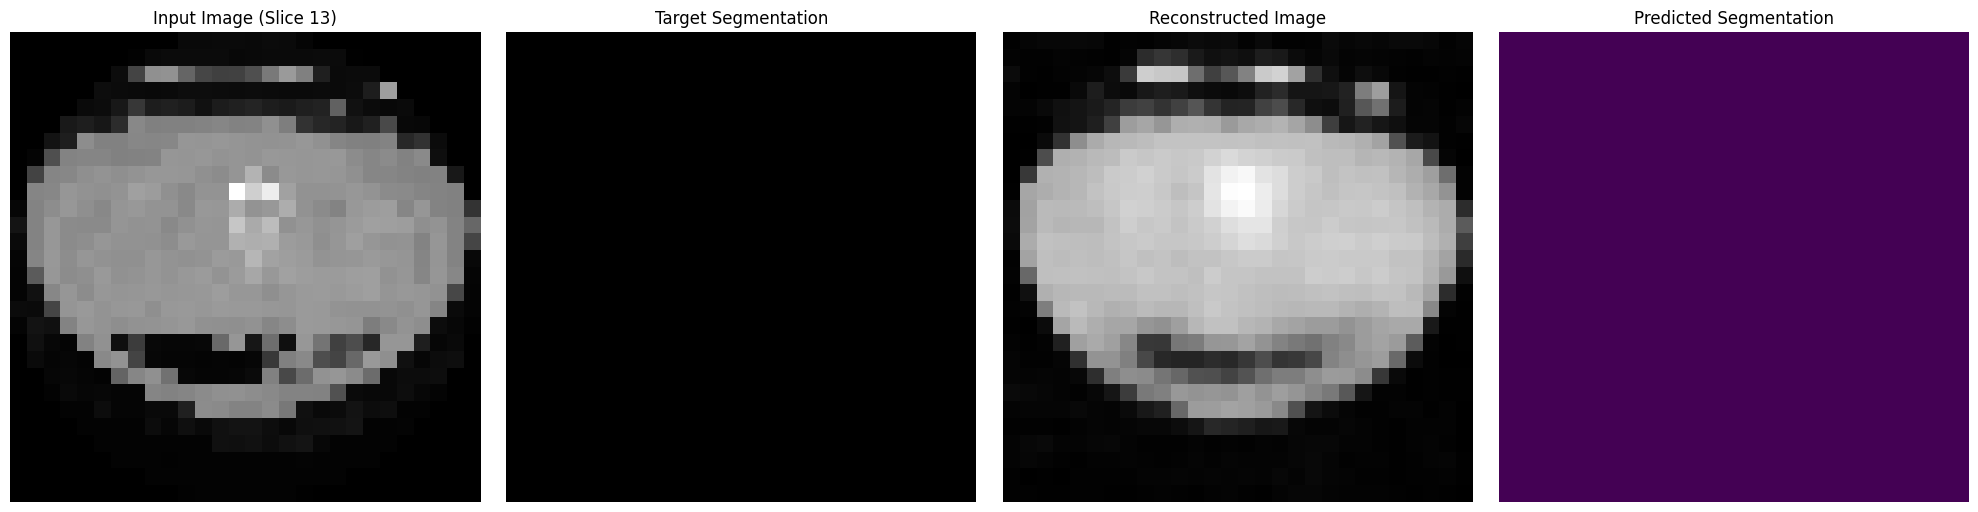

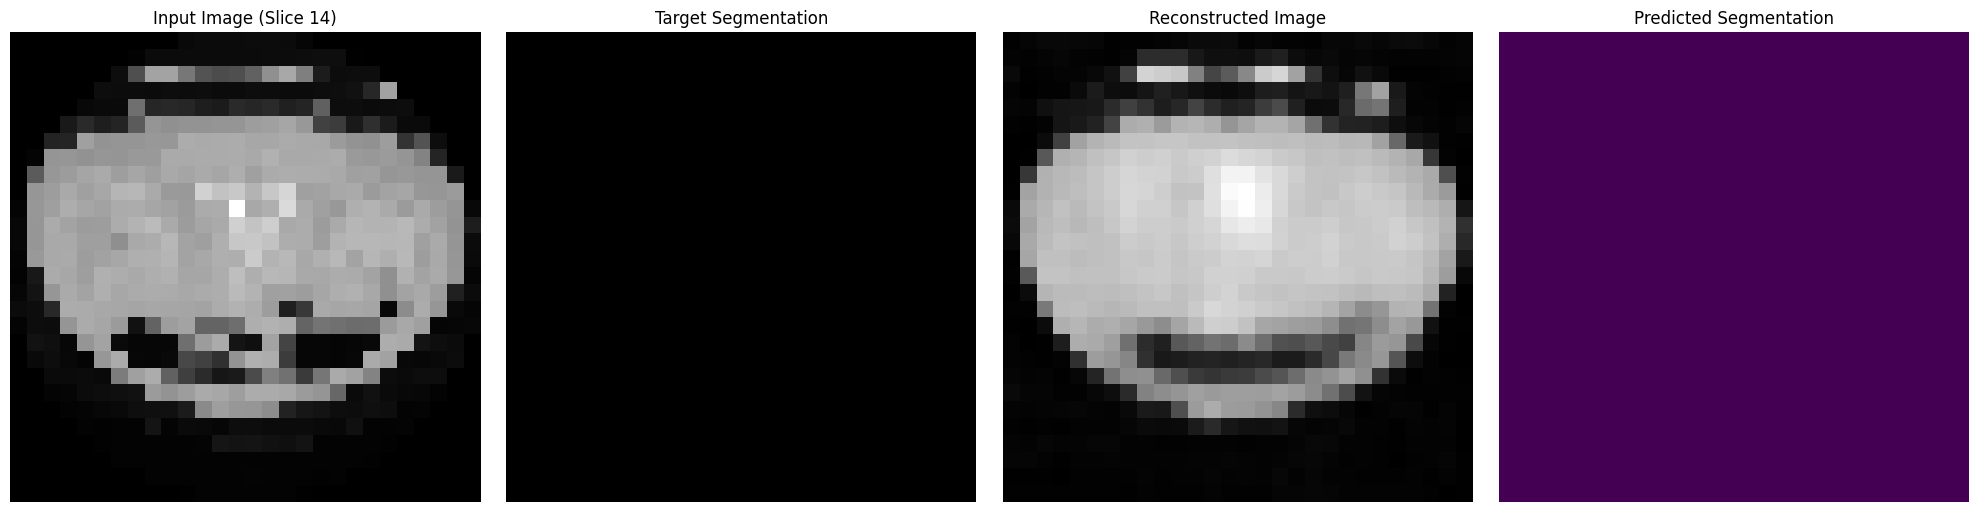

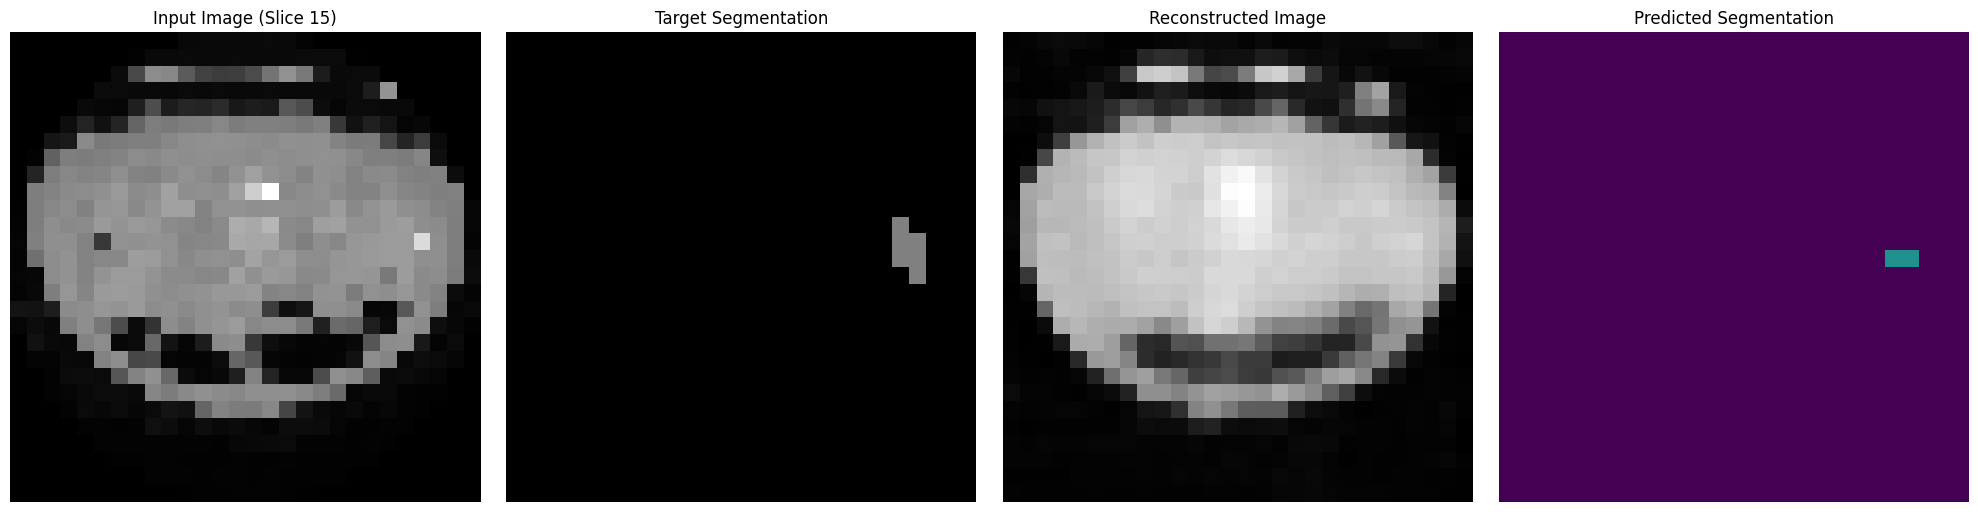

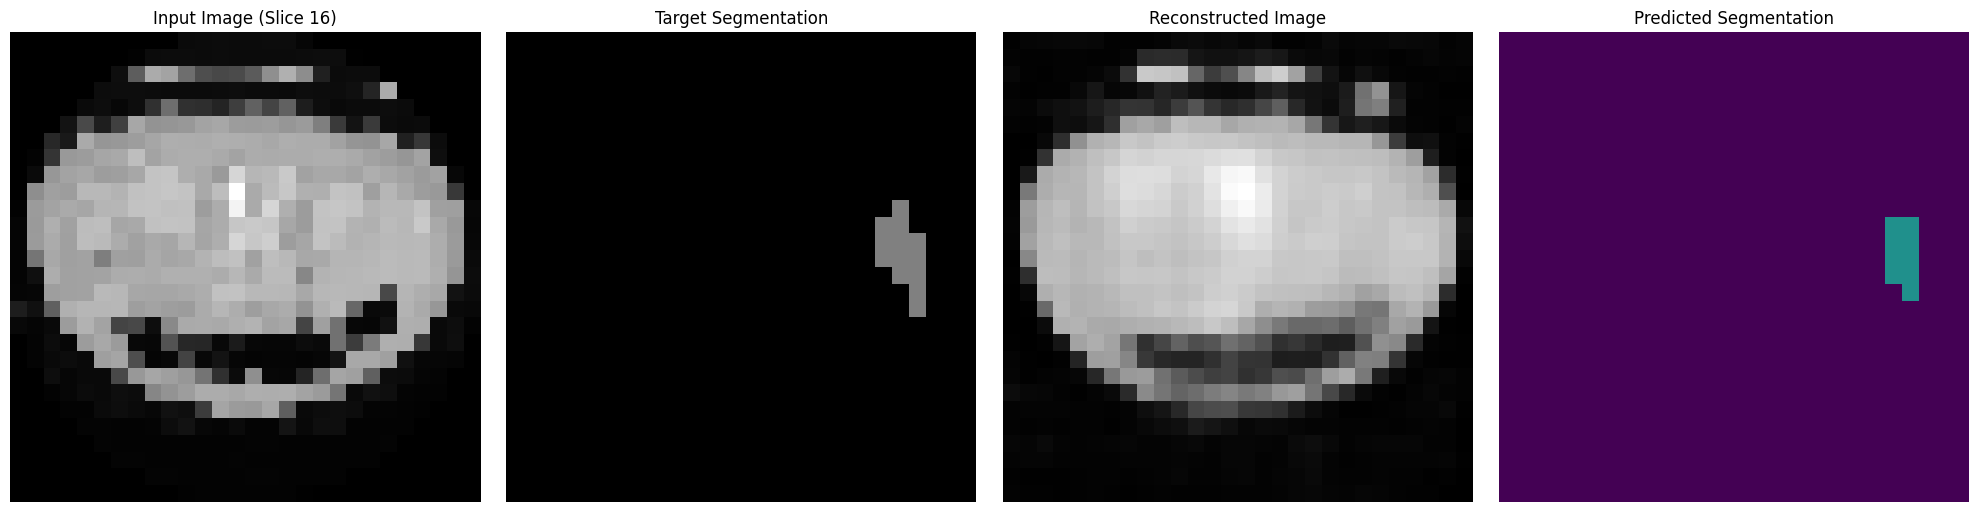

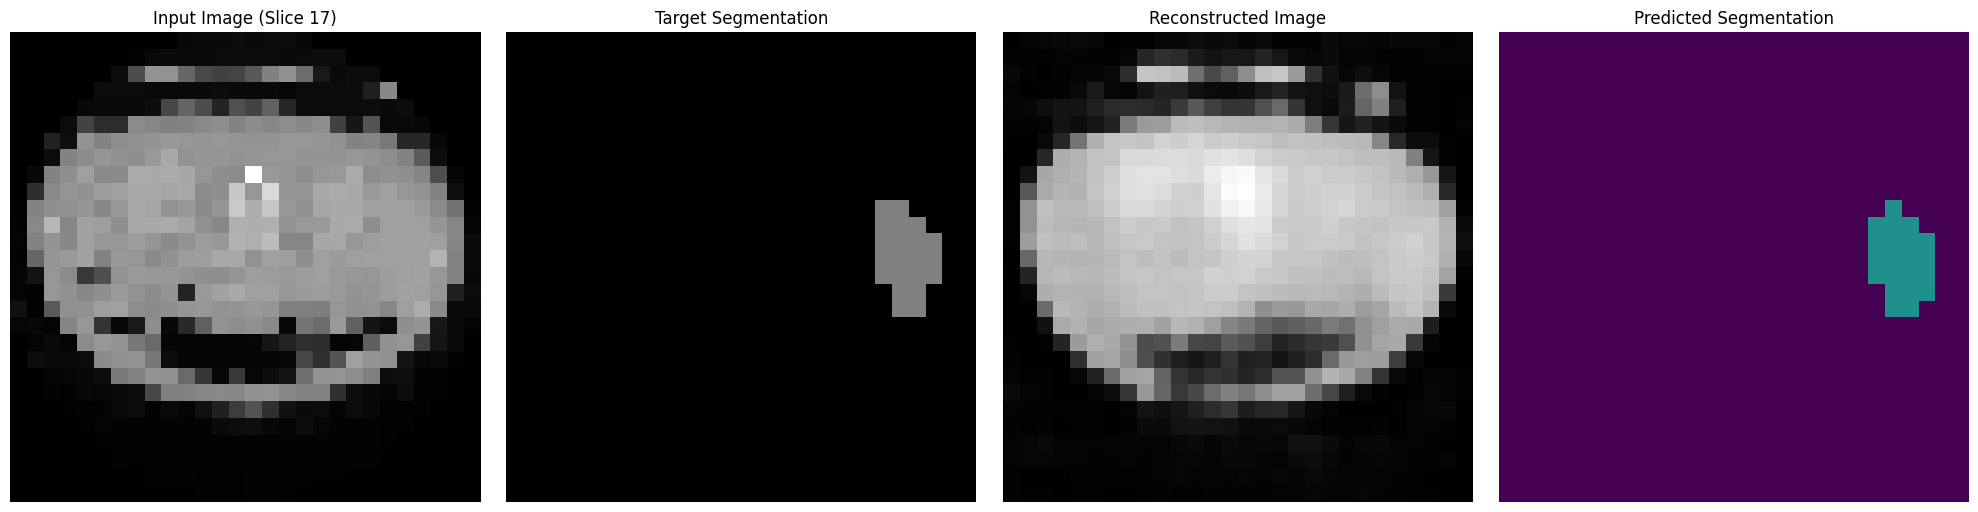

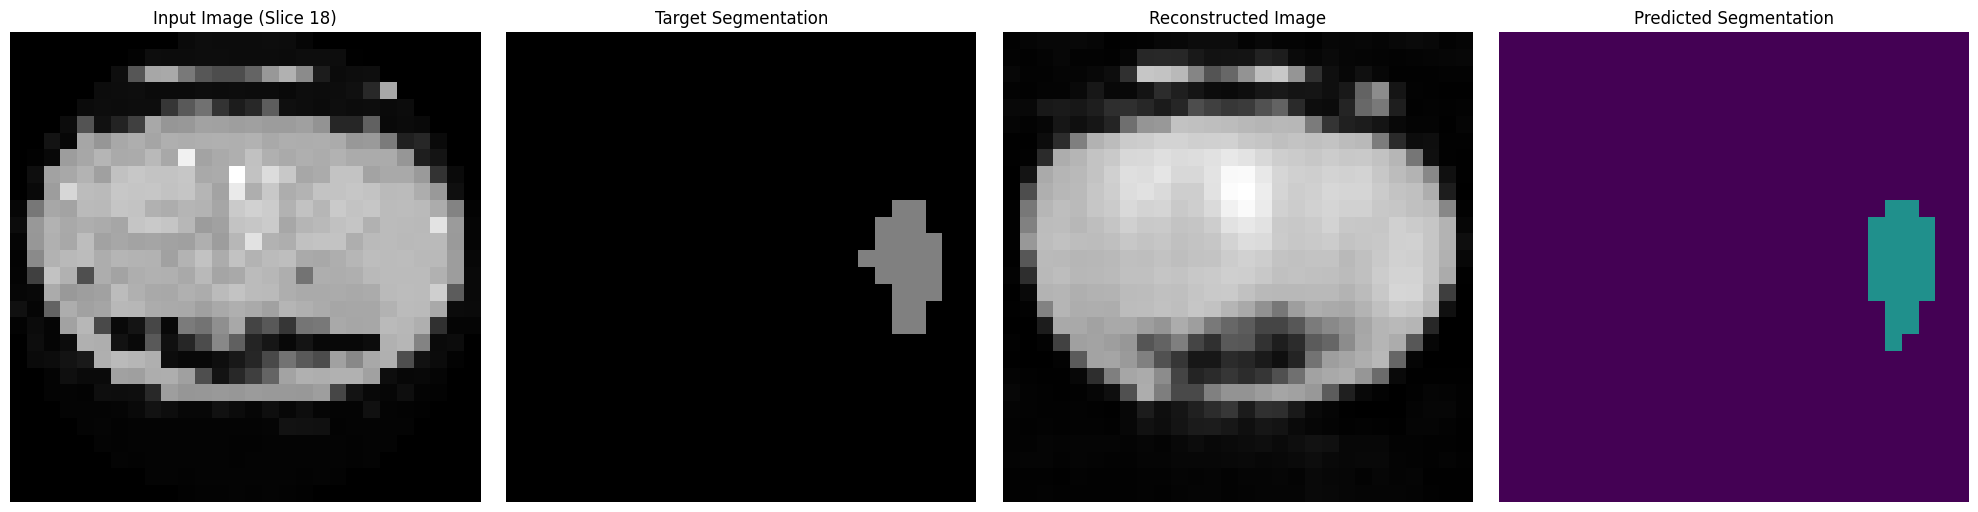

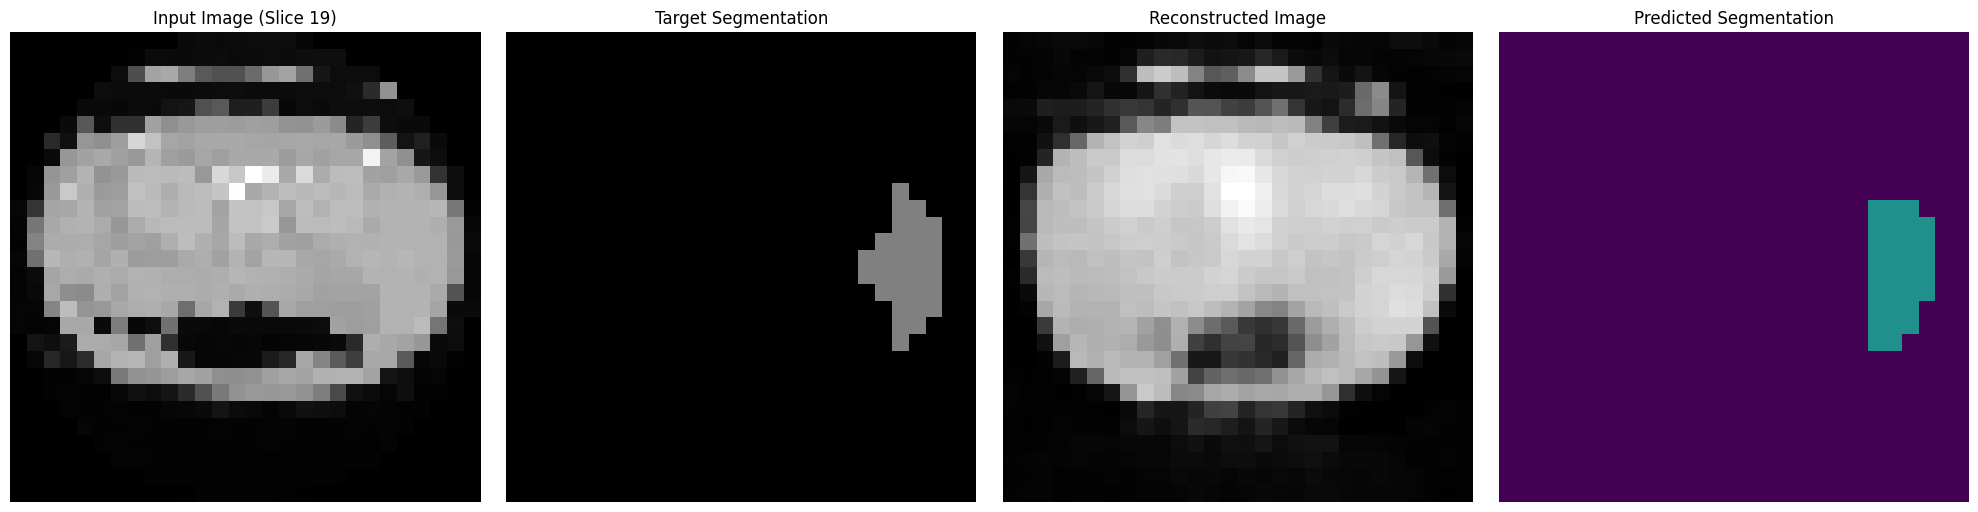

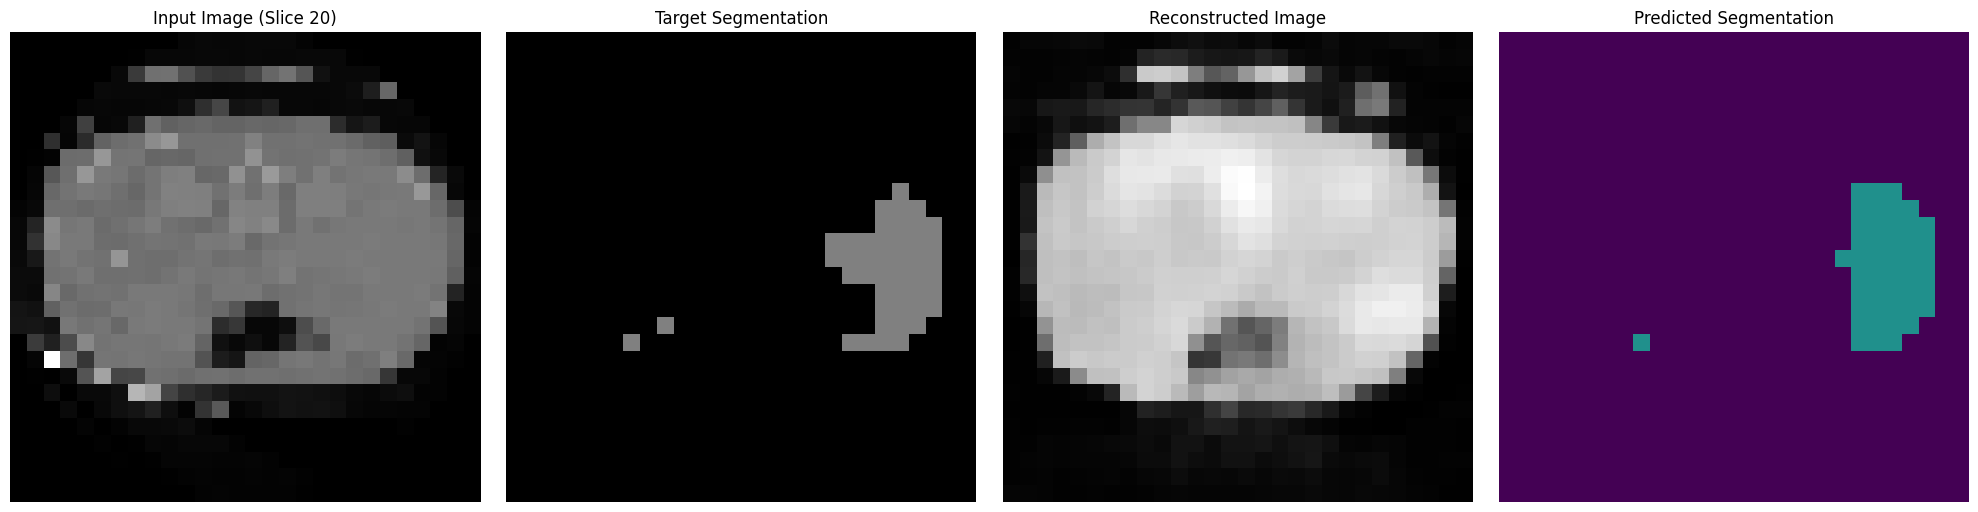

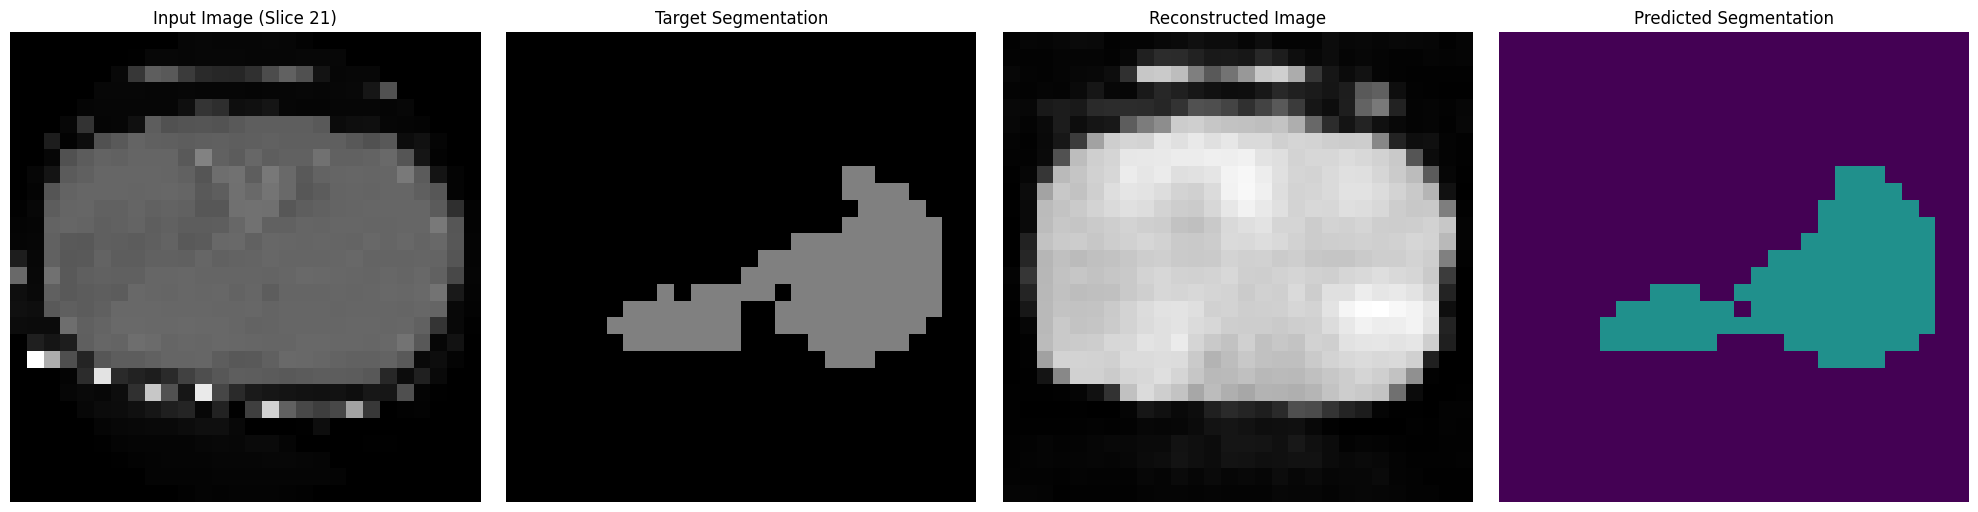

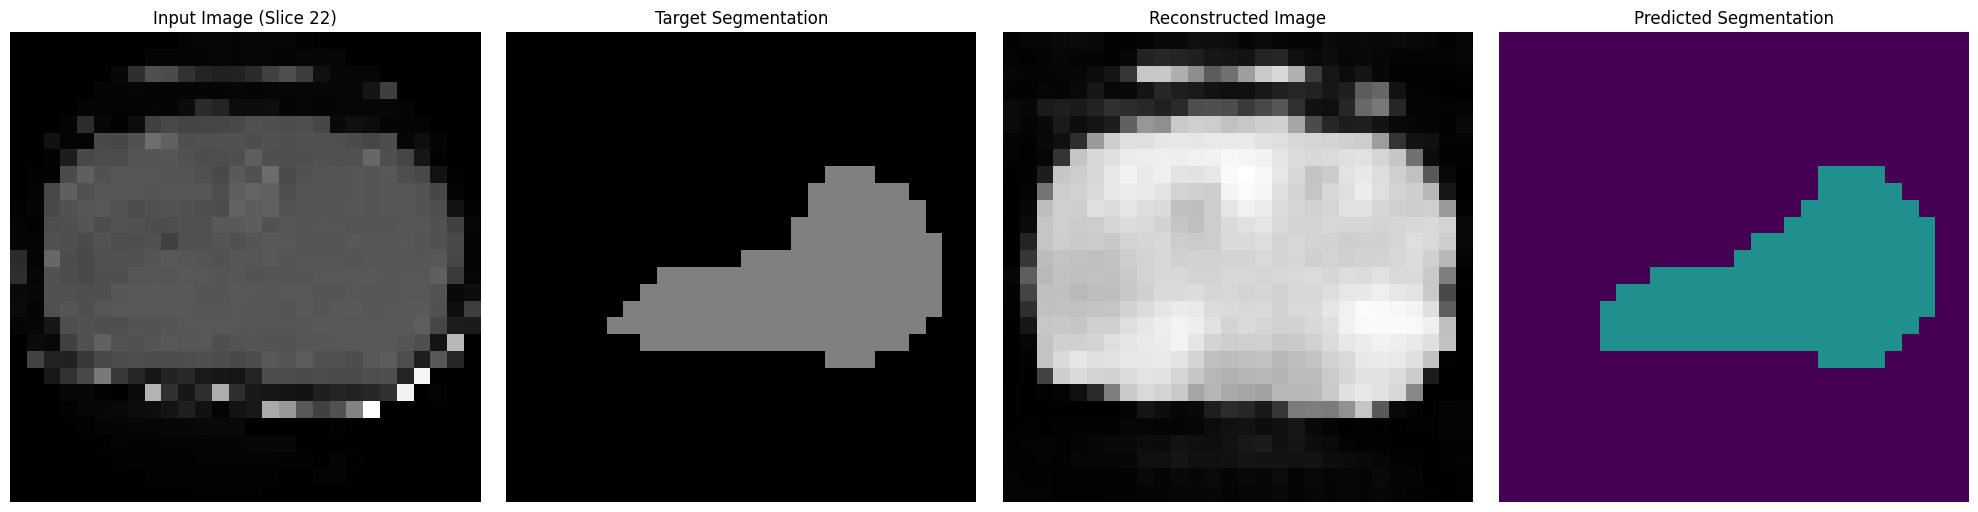

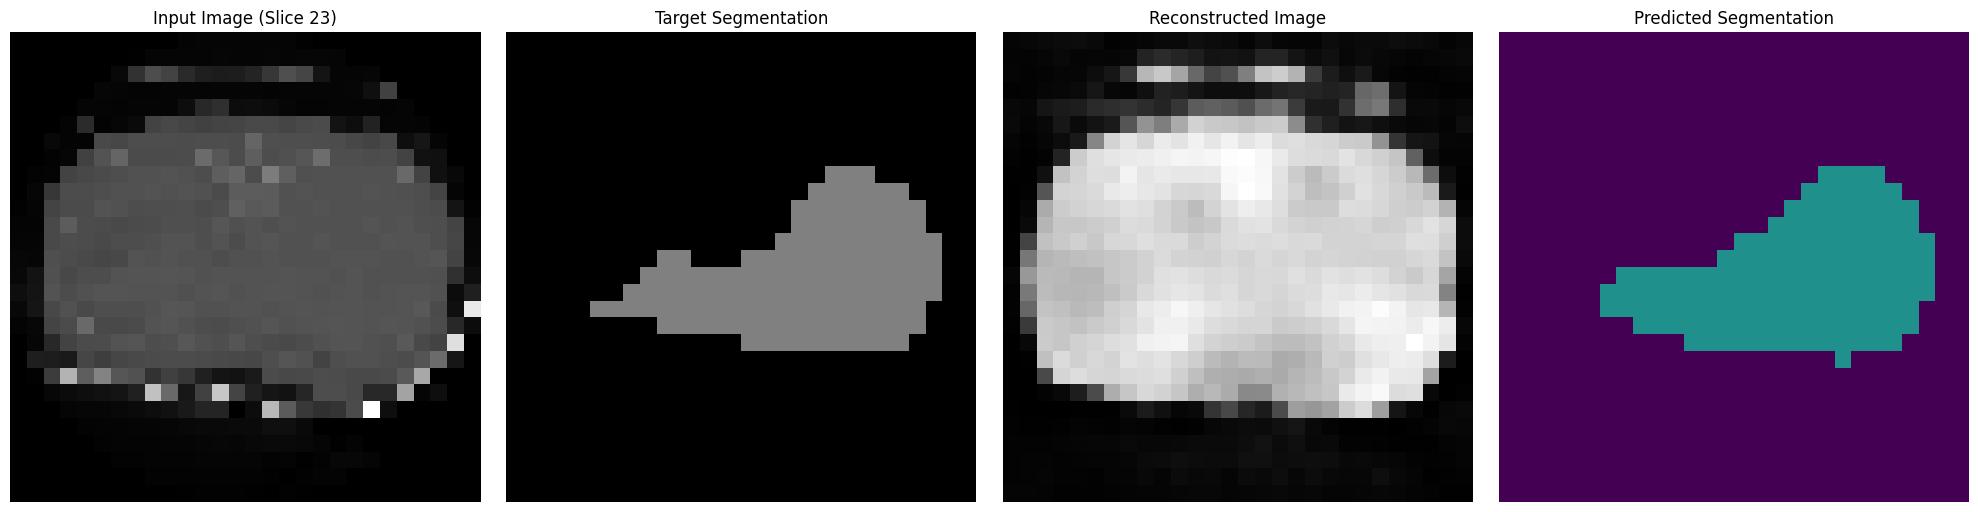

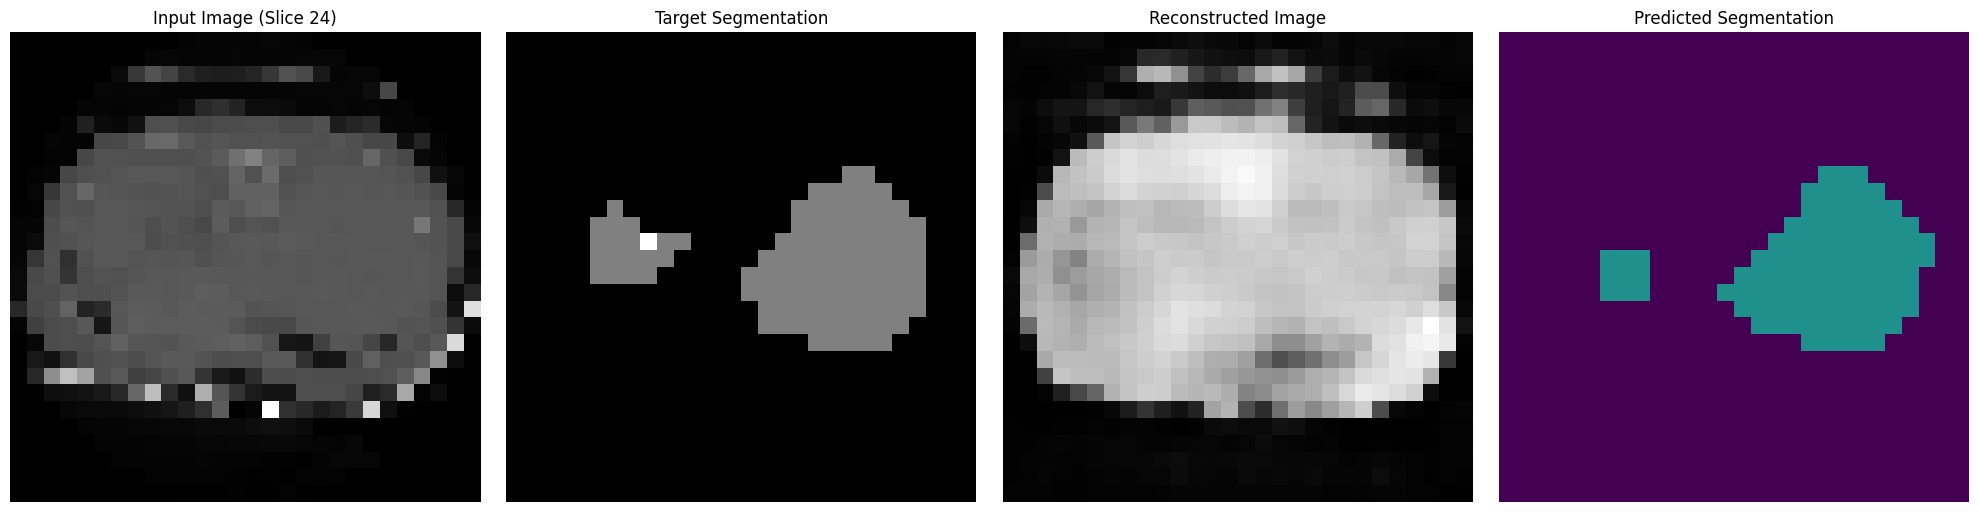

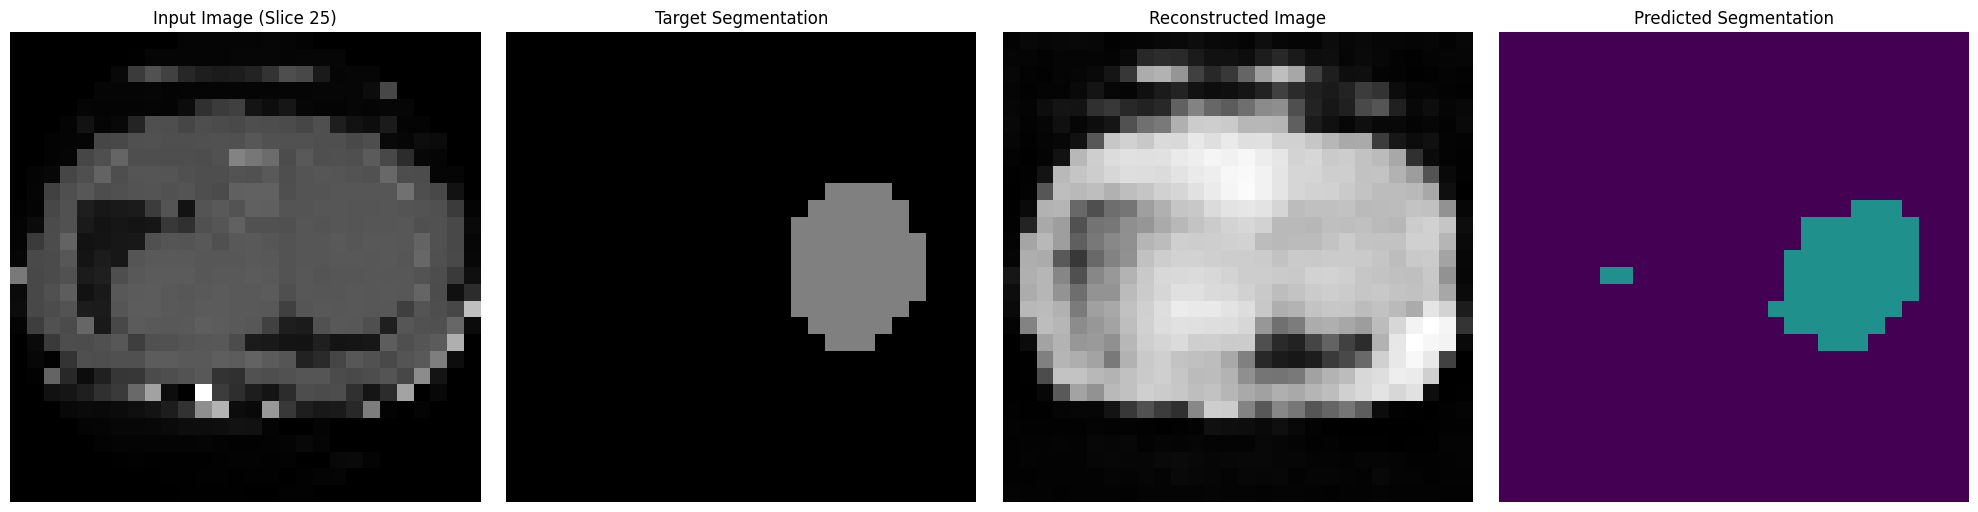

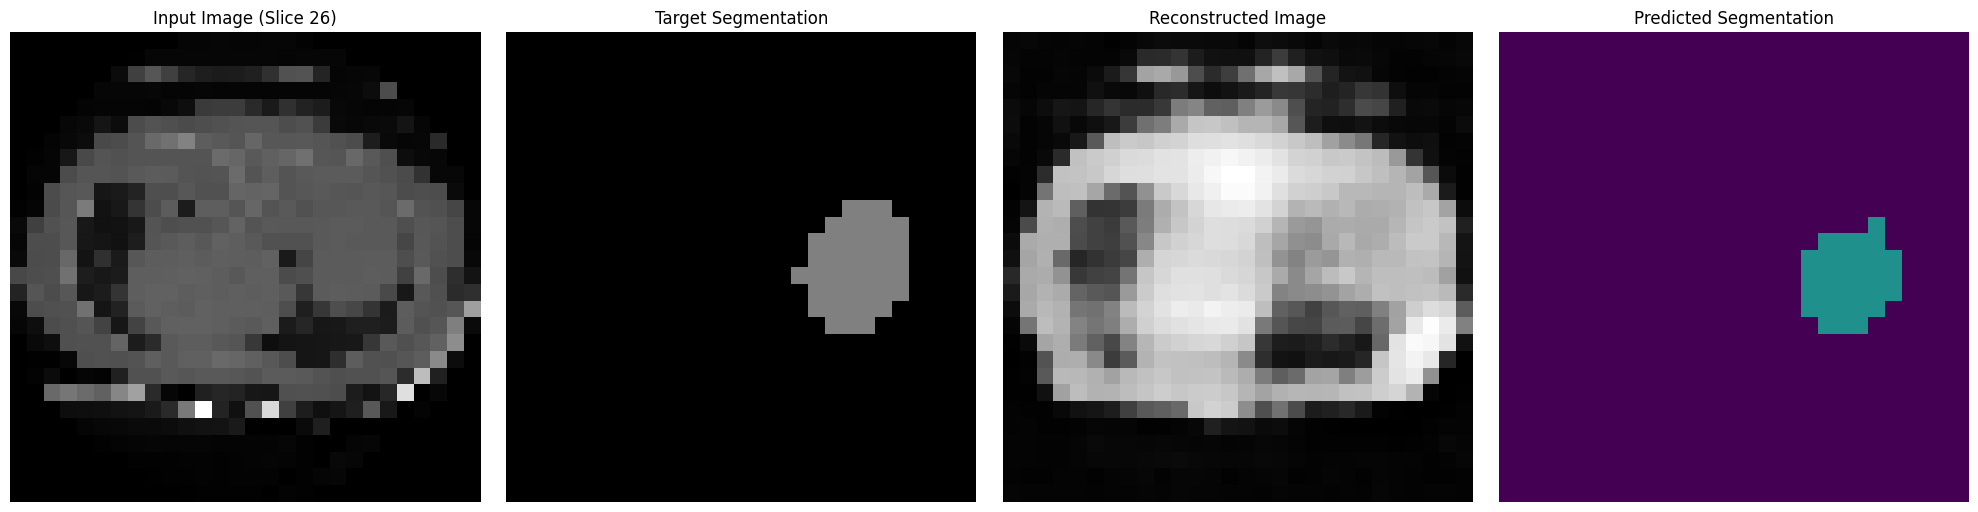

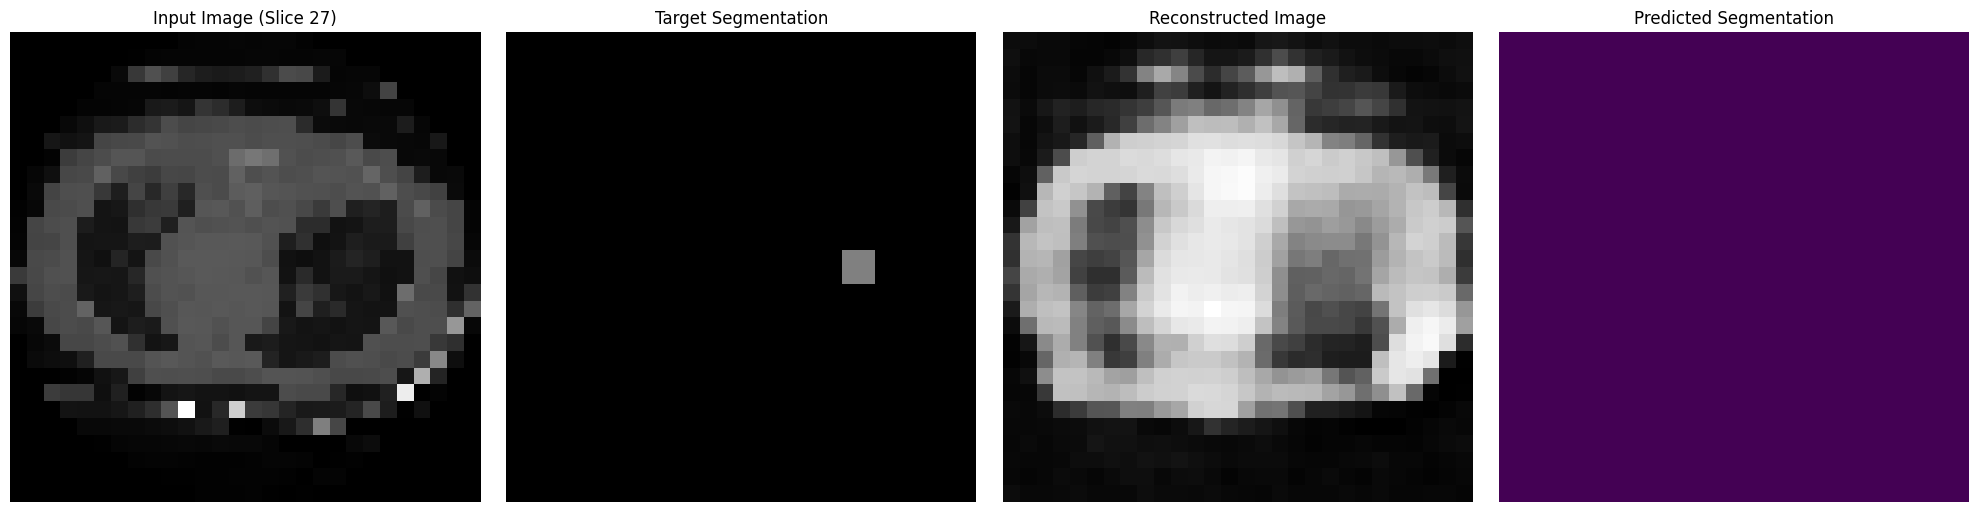

In [14]:
for i in range (28):
    visualize_slices(x_labeled, y_seg_target, recon_out_labeled, seg_out, slice_idx=i)

--- Training the MultiTaskNet on Liver Data ---

--- Epoch 1/31 ---
Batch 0/27 | Total Loss: 1.2022 | Recon Loss: 0.1838 | CE Loss: 1.1104 (Dice not active)
--- Visualizing first training batch ---


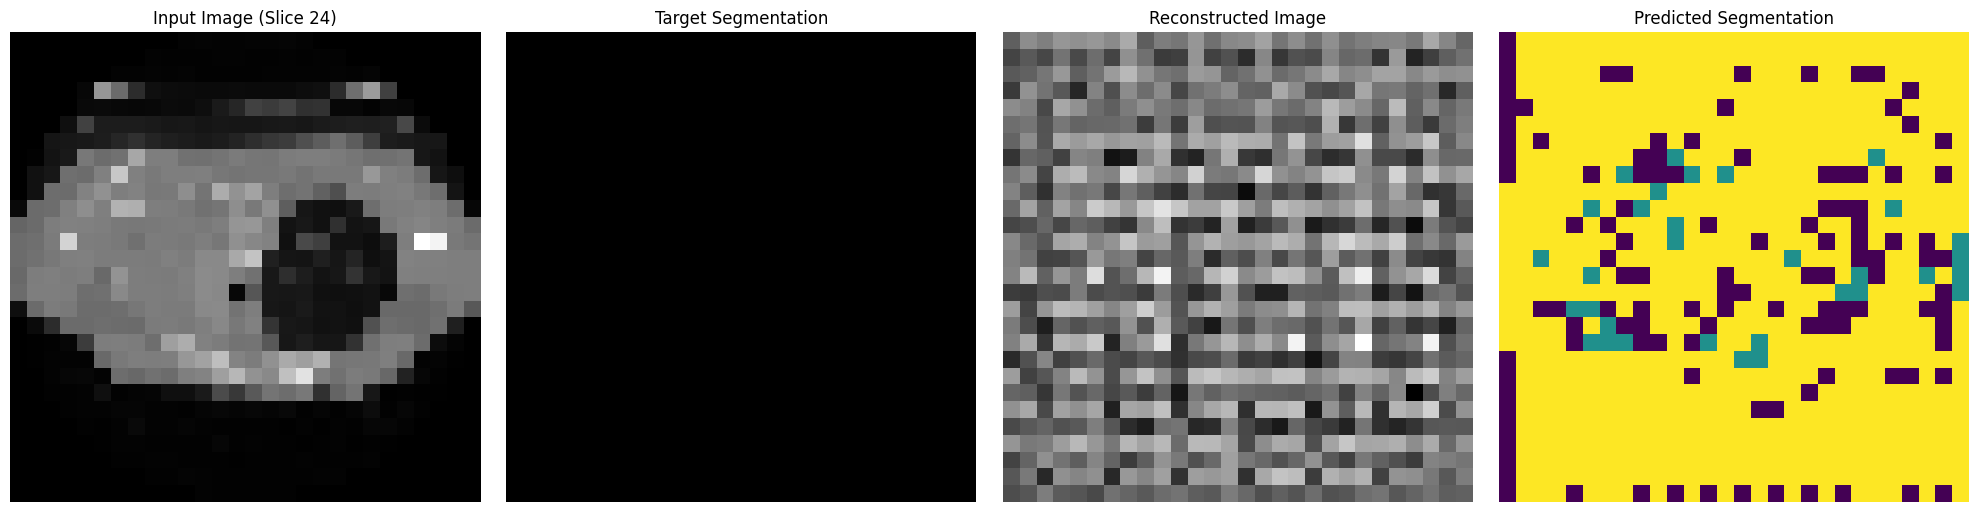

KeyboardInterrupt: 

In [15]:


# OG loop for normal training with labeled data only -> no temporal data
if __name__ == "__main__":
    # start model
    model = MultiTaskNet(
        in_channels=1, 
        num_classes=NUM_CLASSES, 
        latent_dim=LATENT_DIM  
    ).to(device)

    # define loss and optimizer
    loss_fn_seg_dice = DiceLoss(num_classes= NUM_CLASSES)
    loss_fn_seg_cross = nn.CrossEntropyLoss()
    loss_fn_recon = nn.MSELoss()
    optimizer_model = optim.Adam(model.parameters(), lr=1e-3)

    print("--- Training the MultiTaskNet on Liver Data ---")

    NUM_EPOCHS = 31
    
    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
        model.train() 
        
        for batch_idx, (x_labeled, y_seg_target) in enumerate(labeled_loader):
            x_labeled = x_labeled.to(device)       
            y_seg_target = y_seg_target.to(device) 

            optimizer_model.zero_grad()
            
            seg_out, recon_out, _ = model(x_labeled)
            
            loss_seg_cross = loss_fn_seg_cross(seg_out, y_seg_target)
            loss_recon = loss_fn_recon(recon_out, x_labeled)
            total_loss = (loss_seg_cross * 1.0) + (loss_recon * 0.5) 

            loss_seg_dice = 0.0
            if loss_seg_cross.item() < 0.6:
                dice_loss_component = loss_fn_seg_dice(seg_out, y_seg_target)
                total_loss = total_loss + (dice_loss_component * 1)
                loss_seg_dice = dice_loss_component.item()
                
            
            total_loss.backward()
            optimizer_model.step()
            
            if batch_idx % 30 == 0:
                if loss_seg_cross.item() > 0.6:
                    print(f"Batch {batch_idx}/{len(labeled_loader)} | Total Loss: {total_loss.item():.4f} | Recon Loss: {loss_recon.item():.4f} | CE Loss: {loss_seg_cross.item():.4f} (Dice not active)")
                else:
                    print(f"Batch {batch_idx}/{len(labeled_loader)} | Total Loss: {total_loss.item():.4f} | Recon Loss: {loss_recon.item():.4f} | CE Loss: {loss_seg_cross.item():.4f} | DICE Loss: {loss_seg_dice:.4f}")
            if epoch % 10 == 0 and batch_idx % 30 == 0:
                print("--- Visualizing first training batch ---")
                visualize_slices(x_labeled, y_seg_target, recon_out, seg_out)



In [ ]:
visualize_slices(x_labeled, y_seg_target, recon_out, seg_out, slice_idx= 18)


NameError: name 'recon_out' is not defined